# **CSC14120 – PARALLEL PROGRAMMING - FINAL PROJECT**

----
## **1. Thông tin nhóm:**

<center>


| HỌ TÊN                | MSSV      |
|:------------------    |:--------: |
| Đặng Minh Hoàng       |22120110   |
| Hà Đức Huy             |22120133   |
| Trịnh Hoàng Khang      |22120153    |


</center>

## **2. Giảng viên hướng dẫn:**
- **Thầy** Phạm Trọng Nghĩa
- **Thầy** Lê Nhựt Nam
---

# **Section 1: Problem Description**




### **1. Problem Statement**

- **Image Classification Task:**
  - Mục tiêu của dự án là xây dựng hệ thống **Unsupervised Feature Learning** (Học đặc trưng không giám sát) dựa trên kiến trúc mạng nơ-ron **Convolutional Autoencoder**, kết hợp với bộ phân loại SVM trên tập dữ liệu **CIFAR-10** để nhận diện ảnh.
  - Quy trình hoạt động gồm 2 giai đoạn chính:
    - **Giai đoạn 1 (Unsupervised Learning):** Huấn luyện một Convolutional Autoencoder để nén ảnh đầu vào thành một vector đặc trưng (latent representation) và tái tạo lại ảnh gốc. Quá trình này không sử dụng nhãn (labels).
    - **Giai đoạn 2 (Supervised Classification):** Sử dụng phần Encoder đã huấn luyện để trích xuất đặc trưng và đưa vào bộ phân loại SVM (Support Vector Machine) để dự đoán nhãn của ảnh.
- **Motivation for GPU Acceleration:**
  - Việc huấn luyện mạng CNN đòi hỏi khối lượng tính toán ma trận khổng lồ. Trên CPU, quá trình này có thể mất hàng giờ.
  - Sử dụng GPU cho phép song song hóa các phép toán convolution và pooling, giảm thời gian huấn luyện xuống rất nhiều.

### **2. CIFAR-10 Dataset Overview**
- **Dataset Specifications:** Bộ dữ liệu **CIFAR-10** có các thông tin như sau:
  - **Kích thước ảnh:** $32 \times 32$ pixels, 3 kênh màu (RGB)
  - **Số lượng lớp:** 10 lớp (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
  - **Phân chia dữ liệu:**
    - Tập huấn luyện (Training set): 50,000 ảnh.
    - Tập kiểm tra (Test set): 10,000 ảnh.
  - **Format:** Binary files với giá trị uint8 pixel
- **Visualization:**

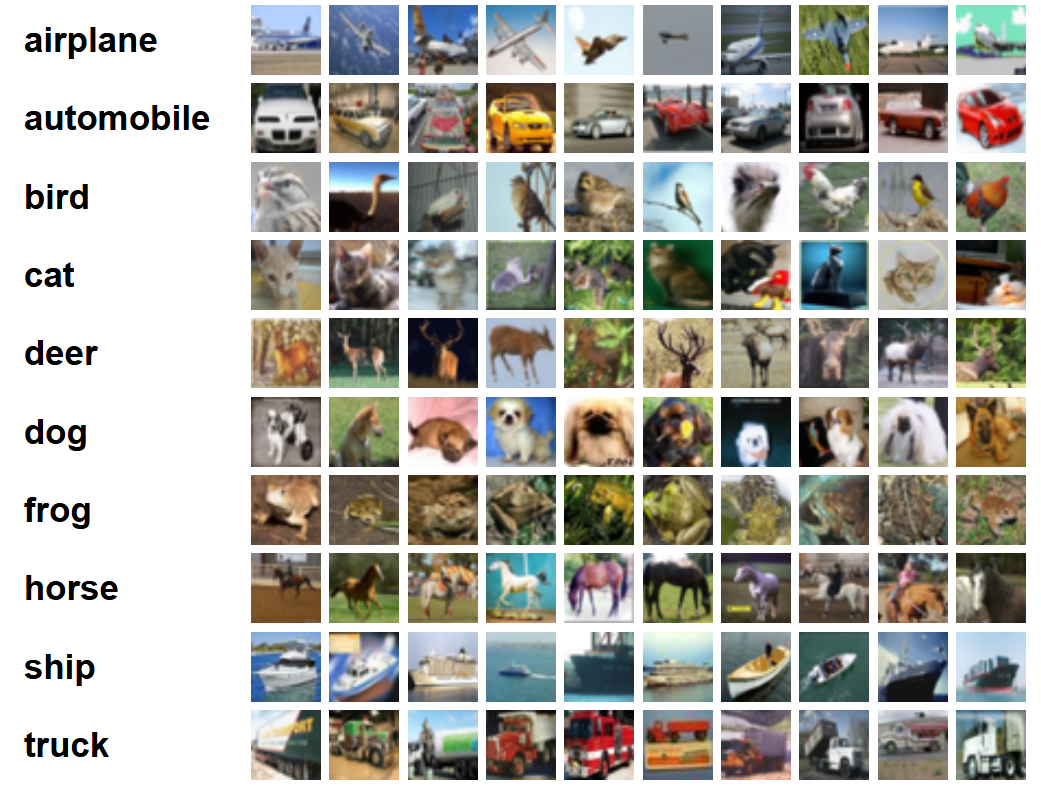

- **Data Preprocessing:**
  - Dữ liệu gốc được lưu trữ dưới dạng binary với giá trị pixel `uint8` từ $[0, 255]$
  - Bước tiền xử lý quan trọng là chuẩn hóa (normalization) các giá trị này về dạng số thực `float` trong khoảng $[0, 1]$ để mạng nơ-ron hội tụ tốt hơn

- **System Outputs:** Sau khi dữ liệu được đưa qua các giai đoạn xử lý, các kết quả đầu ra bao gồm:
  - **Output của Autoencoder:**
    - Ảnh tái tạo có kích thước $32 \times 32 \times 3$
    - Vector đặc trưng có kích thước 8,192 chiều, được trích xuất từ không gian tiềm ẩn (latent space) kích thước $8 \times 8 \times 128$
  - **Output cuối cùng:**
    - Nhãn dự đoán của ảnh (ví dụ: cat, airplane)
    - Độ chính xác phân loại trên tập huấn luyện (train set) và tập kiểm tra (test set)

### **3. Autoencoder Architecture**
- **Architecture Description:**
  - Mạng có cấu trúc đối xứng gồm hai phần: **Encoder** (nén dữ liệu) và **Decoder** (tái tạo dữ liệu).
  - Encoder sử dụng các lớp Conv2D và MaxPool để giảm chiều dữ liệu từ $(32, 32, 3)$ xuống không gian tiềm ẩn (Latent Space).
  - Decoder sử dụng Conv2D và UpSampling để khôi phục lại kích thước ảnh gốc.
- **Layer Dimensions & Transformations:**
  - **Input:** $(32, 32, 3)$
  - **Encoder:**
    - Conv2D (256 filters) $\rightarrow$ MaxPool $\rightarrow$ $(16, 16, 256)$.
    - Conv2D (128 filters) $\rightarrow$ MaxPool $\rightarrow$ $(8, 8, 128)$.
    - **Latent Representation:** Vector đặc trưng có kích thước $(8, 8, 128)$, tương đương 8,192 chiều.
  - **Decoder:**
    - Conv2D (128 filters) $\rightarrow$ UpSample $\rightarrow$ $(16, 16, 128)$.
    - Conv2D (256 filters) $\rightarrow$ UpSample $\rightarrow$ $(32, 32, 256)$.
    - Conv2D (3 filters) $\rightarrow$ Output $(32, 32, 3)$.
- **Visualization:**

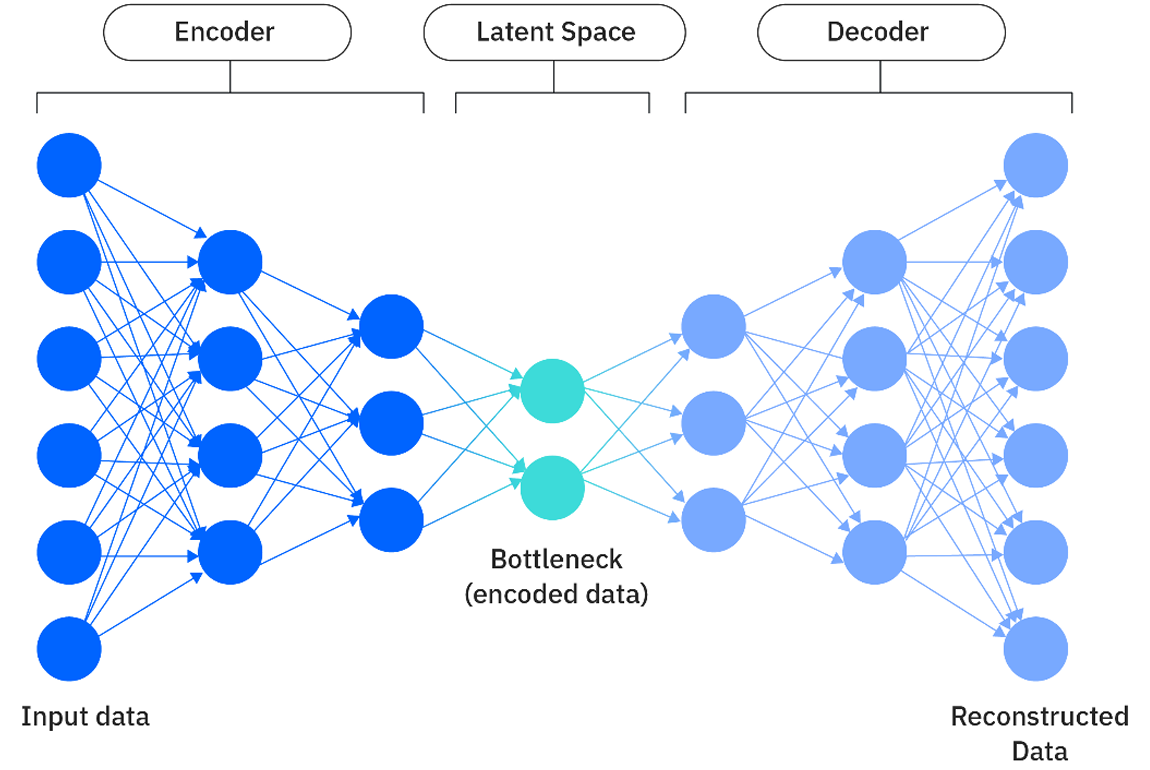

### **4. Project Objectives**
- **Performance Goals:**
  - Thời gian huấn luyện Autoencoder với GPU không quá lâu.
  - Tốc độ tăng tốc (GPU Speedup): $> 20\times$ so với CPU.
  - Độ chính xác phân loại (Test Accuracy) đạt $60-65$%
- **Technical Learning Objectives:**
  - Hiểu và thực hiện song song hóa các lớp mạng nơ-ron (Convolution, Pooling, ReLU) trên CUDA
  - Áp dụng các kỹ thuật tối ưu hóa bộ nhớ GPU (Shared Memory, Coalesced Access, ...)
- **Success Criteria:**
  - Mạng Autoencoder tái tạo được ảnh rõ nét (Reconstruction Loss thấp).
  - Hoàn thành ít nhất 2 phiên bản tối ưu hóa GPU.

# **Section 2: Implementation Phases**

## **Thiết lập thư mục code và dữ liệu cần thiết**

In [ ]:
!apt-get update
!apt-get install -y cuda-nsight-systems-12-2

In [ ]:
!git clone https://github.com/hahuy2004/ParallelProgramming_FinalProject.git
%cd /content/ParallelProgramming_FinalProject

Cloning into 'ParallelProgramming_FinalProject'...
remote: Enumerating objects: 599, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 599 (delta 57), reused 60 (delta 27), pack-reused 485 (from 1)
Receiving objects: 100% (599/599), 17.95 MiB | 13.64 MiB/s, done.
Resolving deltas: 100% (422/422), done.
/content/ParallelProgramming_FinalProject


In [ ]:
%cd /content/ParallelProgramming_FinalProject
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -xzf cifar-10-binary.tar.gz

/content/ParallelProgramming_FinalProject
--2025-12-20 15:49:09--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘cifar-10-binary.tar.gz’

cifar-10-binary.tar 100%[===================>] 162.17M  14.0MB/s    in 13s     

2025-12-20 15:49:24 (12.1 MB/s) - ‘cifar-10-binary.tar.gz’ saved [170052171/170052171]



In [ ]:
# File load dữ liệu
!nvcc -c -arch=sm_75 src/cifar10_loader.cu -o build/cifar10_loader.o

# Autoencoder của CPU
!nvcc -c -arch=sm_75 src/autoencoder_cpu.cu -o build/autoencoder_cpu.o

# Autoencoder của GPU
!nvcc -c -arch=sm_75 cuda/gpu_kernels_naive.cu -o build/gpu_kernels_naive.o
!nvcc -c -arch=sm_75 src/autoencoder_gpu.cu -o build/autoencoder_gpu.o

# Autoencoder của GPU phiên bản Memory Optimization
!nvcc -c -arch=sm_75 cuda/gpu_kernels_optimized_1.cu -o build/gpu_kernels_optimized_1.o
!nvcc -c -arch=sm_75 src/autoencoder_gpu_optimized_1.cu -o build/autoencoder_gpu_optimized_1.o

# Autoencoder của GPU phiên bản Kernel-block Optimization
!nvcc -c -arch=sm_75 cuda/gpu_kernels_optimized_2.cu -o build/gpu_kernels_optimized_2.o
!nvcc -c -arch=sm_75 src/autoencoder_gpu_optimized_2.cu -o build/autoencoder_gpu_optimized_2.o

## **Phase 2.1: CPU Baseline Implementation**

### **1. Objectives**

#### **1.1. Mục tiêu:**
- Xây dựng cấu trúc tổng thể cho dự án và triển khai một phiên bản Autoencoder hoạt động chính xác trên CPU.
- Đảm bảo mô hình thực hiện đúng các bước cốt lõi của thuật toán, bao gồm lan truyền xuôi (forward pass), lan truyền ngược (backward pass) và cập nhật trọng số.

#### **1.2. Lý do giai đoạn này cần thiết:**
- Thiết lập một pipeline xử lý dữ liệu thống nhất và chính xác, có thể tái sử dụng cho các giai đoạn triển khai tiếp theo.
- Kiểm chứng tính đúng đắn của toàn bộ logic thuật toán trong môi trường CPU, trước khi triển khai bằng CUDA với độ phức tạp cao hơn.
- Tạo ra mốc chuẩn (baseline) về hiệu năng (thời gian chạy, độ chính xác) làm cơ sở so sánh và đánh giá hiệu quả tăng tốc khi triển khai trên GPU ở các giai đoạn sau.

### **2. Implementation Details**

#### **2.1. Data Pipeline**

Nhóm xây dựng lớp `CIFAR10Dataset` để xử lý dữ liệu thô từ định dạng binary của CIFAR-10:
  - **Loading:** Đọc 5 file binary cho tập train (50,000 ảnh) và 1 file cho tập test (10,000 ảnh). Mỗi record gồm 1 byte label và 3072 bytes dữ liệu ảnh.
  - **Preprocessing:** Chuyển đổi giá trị pixel từ kiểu `uint8` $[0, 255]$ sang kiểu `float` $[0.0, 1.0]$ để giúp mạng nơ-ron hội tụ tốt hơn.
  - **Batching:** Dữ liệu được xáo trộn (shuffle) và chia thành các batch nhỏ (batch size = 32) để phục vụ quá trình huấn luyện.

#### **2.2. Layer Implementations**

Các lớp mạng được cài đặt thủ công bằng C++ với các vòng lặp lồng nhau (nested loops) để mô phỏng bản chất tính toán tuần tự:
  - **Conv2D:** Sử dụng 4-6 vòng lặp lồng nhau để duyệt qua batch, output channels, input channels, và kích thước không gian (height, width), thực hiện nhân tích chập với kernel $3 \times 3$.
  - **ReLU:** Duyệt qua từng phần tử của mảng activation và áp dụng hàm $f(x) = \max(0, x)$.
  - **MaxPool:** Với mỗi cửa sổ $2 \times 2$ (stride 2), tìm giá trị lớn nhất để giảm kích thước đặc trưng đi một nửa.
  - **UpSampling:** Dùng phương pháp Nearest Neighbor để nhân đôi kích thước ảnh (map mỗi pixel input thành khối $2 \times 2$ ở output).

#### **2.3. Training Loop**

Quá trình huấn luyện diễn ra qua 1 epoch với learning rate = 0.001. Do CPU train khá chậm, vì thế sẽ chỉ sử dụng 500 ảnh để train. Trong mỗi bước:
 - **Forward Pass:** Dữ liệu đi qua Encoder (Conv $\rightarrow$ ReLU $\rightarrow$ MaxPool) rồi qua Decoder (Conv $\rightarrow$ ReLU $\rightarrow$ UpSample).
 - **Loss Computation:** Tính Mean Squared Error (MSE) giữa ảnh gốc và ảnh tái tạo.
 - **Backward Pass:** Tính gradient cho từng lớp theo quy tắc chuỗi (chain rule) từ cuối về đầu.
 - **Weight Update:** Cập nhật trọng số theo Stochastic Gradient Descent (SGD).

### **3. Results:**

Thực hiện train Autoencoder trên 500 ảnh với 1 epoch và learning rate = 0.001:

In [ ]:
!nvcc -arch=sm_75 src/main_phase1.cu build/cifar10_loader.o build/autoencoder_cpu.o -o build/phase1

In [ ]:
!./build/phase1

PHASE 1: CPU Baseline Implementation

=== Loading CIFAR-10 Dataset ===
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000

Dataset loaded successfully!
Full training images: 50000
Test images: 10000
Image size: 32x32x3

=== Training CPU Autoencoder (Sanity Check) ===
NOTE: CPU Phase - Training with 500 images, 1 epoch for sanity check & benchmarking
Training CPU Autoencoder...
Images: 500, Batch size: 32, Epochs: 1, LR: 0.001
Epoch 1/1 - Loss: 0.247987 - Time: 2210.69s
Training completed in 2210.69 seconds

=== Training Summary (CPU Baseline - Sanity Check) ===
Total training time: 2210.69 seconds
Time per epoch: 2210.69 seconds
Images processed: 500
Weights saved to weights/autoencoder_cpu.bin

=== Phase 1 Completed ===
Weights saved to: weights/autoencoder_cpu.bin


Reconstruct 10 ảnh trong tập test để kiểm tra độ chính xác của Autoencoder

In [ ]:
!nvcc -arch=sm_75 src/reconstruct.cu \
    build/cifar10_loader.o \
    build/autoencoder_cpu.o \
    build/autoencoder_gpu.o \
    build/gpu_kernels_naive.o \
    build/autoencoder_gpu_optimized_1.o \
    build/autoencoder_gpu_optimized_2.o \
    build/gpu_kernels_optimized_1.o \
    build/gpu_kernels_optimized_2.o \
    -o build/reconstruct

In [ ]:
!./build/reconstruct cpu 10

CIFAR-10 Autoencoder Reconstruction

Loading CIFAR-10 dataset...
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000
Dataset loaded: 10000 test images

Loading weights from: weights/autoencoder_cpu.bin
Starting reconstruction loop...
Weights loaded from weights/autoencoder_cpu.bin
  Finished image 1/10
  Finished image 2/10
  Finished image 3/10
  Finished image 4/10
  Finished image 5/10
  Finished image 6/10
  Finished image 7/10
  Finished image 8/10
  Finished image 9/10
  Finished image 10/10

Success! Images are saved in: results/reconstruction_cpu


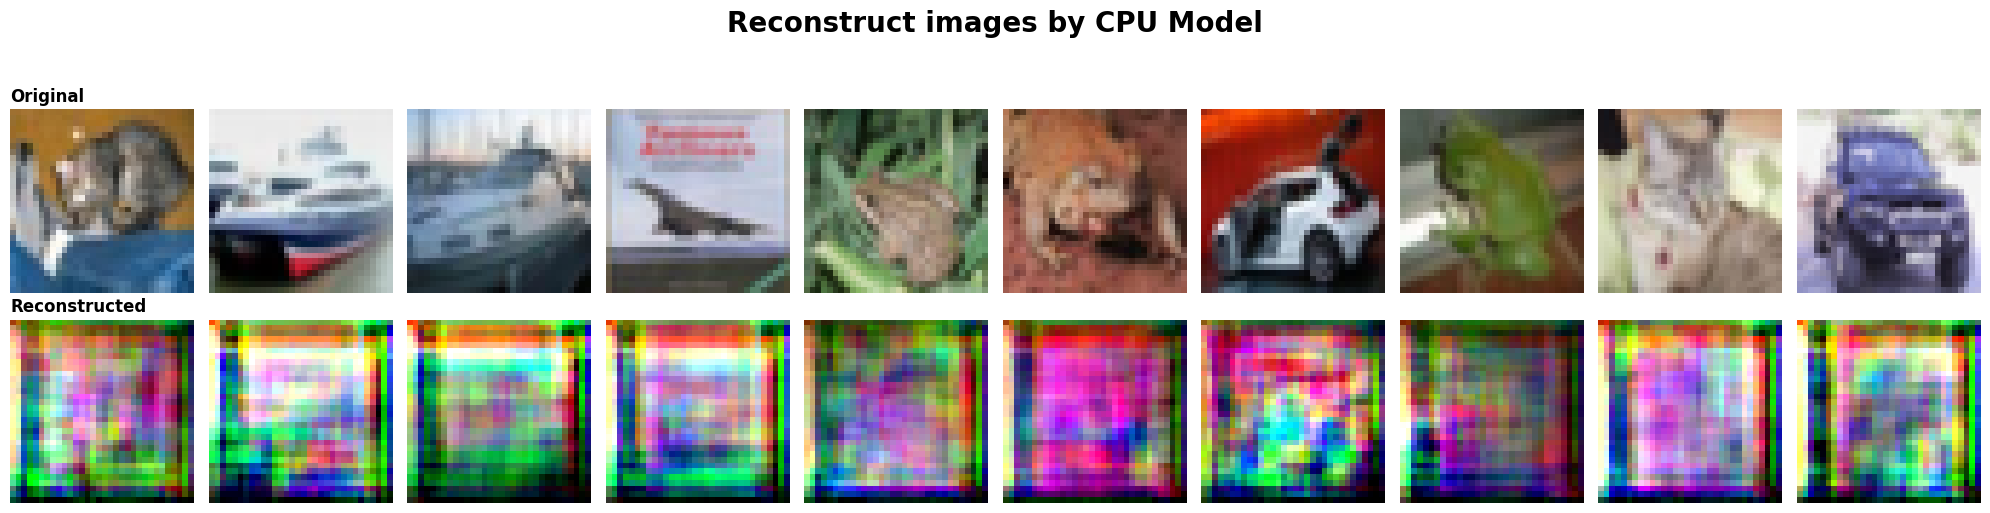

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

base_path = "/content/ParallelProgramming_FinalProject/results/reconstruction_cpu"
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
plt.suptitle("Reconstruct images by CPU Model", fontsize=20, fontweight='bold', y=1.05)

for i in range(num_images):
    # Construct filenames
    orig_name = f"img_{i}_orig.ppm"
    recon_name = f"img_{i}_recon.ppm"

    # Open images
    orig_img = Image.open(os.path.join(base_path, orig_name))
    recon_img = Image.open(os.path.join(base_path, recon_name))

    # Plot Original
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Original", loc='left', fontweight='bold')

    # Plot Reconstructed
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Reconstructed", loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

### **4. Key Takeaways:**
- **Về thuật toán:** Việc cài đặt phép tích chập (Convolution) bằng các vòng lặp lồng nhau giúp làm rõ cơ chế hoạt động của thuật toán. Tuy nhiên, cách tiếp cận này bộc lộ rõ độ phức tạp tính toán rất lớn, đặc biệt khi kích thước ảnh và số lượng kernel tăng lên.
- **Về hiệu năng:** Quá trình huấn luyện trên CPU diễn ra cực kỳ chậm (mất nhiều thời gian để hội tụ) do các phép tính được thực hiện tuần tự theo từng pixel. Cách xử lý này không khai thác được tính độc lập giữa các phép toán trong không gian ảnh, dẫn đến thời gian hội tụ kéo dài và hiệu năng tổng thể thấp.
- **Định hướng GPU:** Việc các vòng lặp ngoài (duyệt pixel h, w) độc lập với nhau là dấu hiệu cho thấy thuật toán có thể song song hóa một cách hiệu quả. Mỗi luồng GPU có thể đảm nhận tính một pixel output riêng, giúp tăng tốc quá trình huấn luyện.

## **Phase 2.2: Naive GPU Implementation**

### **1. Objectives:**
Mục tiêu của giai đoạn này là:
- Chuyển đổi kiến trúc Autoencoder từ từ phiên bản CPU sang GPU, áp dụng song song hóa cơ bản để khai thác khả năng tính toán của GPU.
- Kiểm chứng tính đúng đắn của các CUDA kernel thông qua việc so sánh kết quả đầu ra với phiên bản CPU.
- Thiết lập một phiên bản GPU nền (GPU baseline) về hiệu năng, làm cơ sở đánh giá mức độ cải thiện của các kỹ thuật tối ưu hóa được áp dụng ở các giai đoạn tiếp theo.


### **2. Implementation Details**

#### **2.1. Memory Management**

Phần bộ nhớ của autoencoder sẽ được quản lý như sau:
- **Weight Storage (Trọng số của mô hình):**
  - Tất cả trọng số sẽ được khởi tạo trên **HOST** với phương pháp khởi tạo He initialization.
  - Ngay trong constructor của Autoencoder, trọng số được **sao chép lần duy nhất** từ HOST sang DEVICE và lưu trên đấy luôn.
  - Trong quá trình huấn luyện ta sẽ update trực tiếp trọng số trên DEVICE.

- **Activation Buffers (Kết quả trung gian giữa các layer):**
  - Bộ nhớ dành cho các activation output này được cấp phát **một lần duy nhất** trong constructor với kích thước tương ứng cố định.
  - Các buffer này được tái sử dụng cho mỗi `train_step()` mà không cần reallocate.

- **Gradient (Gradient qua các layer):**
  - Tương tự activations, gradient (d_grad_conv5, d_grad_up2, ..., d_grad_conv1) được cấp phát **một lần** với kích thước tương ứng.
  - Loss buffer (d_loss) được cấp phát là 1 float để lưu MSE loss scalar.

- **Loss Computation:**
  - Được tính bằng kernel MSE loss và **tự động accumulate** trên DEVICE bằng `atomicAdd`.
  - Copy về HOST chỉ khi cần để report.

- **Free memory**: Toàn bộ bộ nhớ cấp phát sẽ được giải phóng bằng Destructor của Autoencoder.

#### **2.2. CUDA Kernel Design**

Các hàm trong phần này được xây dựng dựa trên phiên bản CPU, do đó cấu trúc và logic cài đặt nhìn chung là tương đồng.

##### **2.2.1. Forward pass**
- **Conv2D forward kernel**:
  - Mỗi thread sẽ tính toán một phần tử tại một channel trong output
  - Mỗi thread sẽ thực hiện 3 vòng lặp để thực hiện phép tính tích chập
  - Thread đọc giá trị phần tử và trọng số trên Global memory
- **ReLU foward kernel**:
  - Mỗi thread chịu trách nhiệm tính toán một phần tử trên output
  - Dùng: output[idx] = fmaxf(0.0f, input[idx])
- **MaxPool Kernel**:
  - Mỗi thread chịu trách nhiệm tính toán một phần tử trên output.
  - Thread xác định vị trí cửa sổ 2x2 tương ứng trên input, thực hiện 4 phép đọc global memory để tìm giá trị lớn nhất (fmaxf) và ghi vào output (giả sử pool-size 2x2)
- **Upsample Kernel**:
  - Mỗi thread chịu trách nhiệm tính toán một phần tử trên output.
  - Thread tính toán tọa độ tương ứng trên input bằng phép chia nguyên (oh / scale_factor, ow / scale_factor) để lấy giá trị phần tử gần nhất và sao chép sang output.

##### **2.2.2. Backward pass**

- **ReLU Backward Kernel**
  - Thread chạy trên **Input** của lớp ReLU. Một thread chịu trách nhiệm cho một phần tử.
  - Thread đọc grad_output và giá trị input ban đầu. Nếu input > 0, gradient được truyền về (grad_input = grad_output), ngược lại grad_input = 0
- **MaxPool Backward Kernel:**:
  - Thread chạy trên **Output** của lớp MaxPool. Một thread chịu trách nhiệm cho một phần tử .
  - Ở đây thread phải đọc lại input gốc để xác định vị trí (index) của phần tử max trong cửa sổ 2x2.
  - Sử dụng atomicAdd để cộng dồn gradient vào đúng vị trí đó trên grad_input. Thật ra nếu các cửa sổ không đè lên nhau thì không cần, nhưng ta tính luôn cả trường hợp đấy.
- **Upsample backward kernel**:
  - Thread chạy trên **Input** của lớp Upsample. Một thread chịu trách nhiệm cho một phần tử.
  - Thread thực hiện cộng dồn gradient từ 4 vị trí pixel tương ứng trên grad_output (giả sử scale_factor = 2)
- **Conv2D backward kernel**: Phép tính gradient cho layer Convolution được tách thành 3 kernel riêng:
  - **Weight Gradient Kernel (dW)**:
    - Mỗi thread tính gradient cho một phần tử trọng số cụ thể
    - Thread thực hiện vòng lặp qua toàn bộ không gian không gian output (H_out, W_out) để tích lũy tích của grad_output và input.
    - Ở phương pháp hiện tại ta dùng Global memory nên rất tốn kém
  - **Bias Gradient Kernel (db)**:
    - Mỗi thread tính gradient cho một bias
    - Thread thực hiện vòng lặp cộng dồn toàn bộ giá trị trong grad_output thuộc channel đó.
  - **Input Gradient Kernel (dX)**:
    - Mỗi thread tính gradient cho một phần tử của grad_input
    - Thread thực hiện một phép full convolution ngược: duyệt qua tất cả output channels và các vị trí kernel có ảnh hưởng đến pixel input hiện tại để cộng dồn gradient.

##### **2.2.3. Loss**:
- **MSE Loss kernel**:
  - Gradient computation: Mỗi thread tính đạo hàm 2 * (pred - target) / N cho một phần tử.
  - Loss accumulation: Mỗi thread tính bình phương sai số (pred - target)^2 / N và sử dụng atomicAdd để cộng dồn vào biến loss



#### **2.3. Key code snippets**

Dưới đây là các đoạn code minh họa cách cài đặt hàm Conv2D forward

```cpp
void launch_conv2d_forward(
    const float* input,
    const float* weight,
    const float* bias,
    float* output,
    int C_in, int H_in, int W_in,
    int C_out, int H_out, int W_out,
    int kernel_size, int stride, int padding)
{
    // Grid: (C_out, ceil(H_out/16), ceil(W_out/16))
    // Block: (1, 16, 16)
    dim3 blockDim(1, 16, 16);
    dim3 gridDim(C_out, (H_out + 15) / 16, (W_out + 15) / 16);
    
    conv2d_kernel<<<gridDim, blockDim>>>(
        input, weight, bias, output,
        C_in, H_in, W_in, C_out, H_out, W_out, kernel_size, stride, padding);
    
    CUDA_CHECK(cudaGetLastError());
}

// Mỗi thread chịu trách nhiệm tính giá trị cho một pixel tại đầu ra (output pixel)
__global__ void conv2d_kernel(
    const float* input,   // Dữ liệu đầu vào [Batch, C_in, H, W]
    const float* weight,  // Bộ lọc [C_out, C_in, K, K]
    const float* bias,    // Bias [C_out]
    float* output,        // Kết quả đầu ra [C_out, H_out, W_out]
    int C_in, int H_in, int W_in,
    int C_out, int H_out, int W_out,
    int kernel_size, int stride, int padding)
{
    // Xác định vị trí pixel output mà thread này phụ trách
    int oc = blockIdx.x;  // Output Channel
    int oh = blockIdx.y * blockDim.y + threadIdx.y;  // Output Height
    int ow = blockIdx.z * blockDim.z + threadIdx.z;  // Output Width
    
    // Boundary Check: Đảm bảo thread không truy cập ngoài mảng output
    if (oc >= C_out || oh >= H_out || ow >= W_out) return;
    
    float sum = 0.0f;
    
    // Convolution Operation: Duyệt qua các kênh input và cửa sổ kernel
    for (int ic = 0; ic < C_in; ic++) {
        for (int kh = 0; kh < kernel_size; kh++) {
            for (int kw = 0; kw < kernel_size; kw++) {
                // Tính tọa độ trên ảnh input dựa trên stride và padding
                // Công thức: index_in = index_out * stride + offset - padding
                int ih = oh * stride + kh - padding;
                int iw = ow * stride + kw - padding;
                
                float input_val = 0.0f;
                // Kiểm tra biên (Padding check): Nếu nằm ngoài ảnh thật thì giá trị là 0
                if (ih >= 0 && ih < H_in && iw >= 0 && iw < W_in) {
                    // Đọc dữ liệu từ Global Memory
                    input_val = input[ic * H_in * W_in + ih * W_in + iw];
                }
                
                // Tính flatten index của trọng số
                int weight_idx = ((oc * C_in + ic) * kernel_size + kh) * kernel_size + kw;
                
                // Tích chập
                sum += input_val * weight[weight_idx];
            }
        }
    }
    
    // Cộng Bias và ghi kết quả vào Global Memory
    sum += bias[oc];
    output[oc * H_out * W_out + oh * W_out + ow] = sum;
}

```


### **3. Results:**

Thực hiện train autoencoder với toàn bộ dữ liệu trên 10 epoch, batch_size = 64 và learning_rate = 0.001:

In [ ]:
!nvcc -arch=sm_75 src/main_phase2.cu build/cifar10_loader.o build/autoencoder_gpu.o build/gpu_kernels_naive.o -o build/phase2

In [ ]:
!./build/phase2

Streaming output truncated to the last 5000 lines.
Batch [510/782] Avg Loss: 0.00683442
Batch [511/782] Avg Loss: 0.00631398
Batch [512/782] Avg Loss: 0.00617344
Batch [513/782] Avg Loss: 0.00545697
Batch [514/782] Avg Loss: 0.00612815
Batch [515/782] Avg Loss: 0.00687422
Batch [516/782] Avg Loss: 0.00652018
Batch [517/782] Avg Loss: 0.00650817
Batch [518/782] Avg Loss: 0.00686105
Batch [519/782] Avg Loss: 0.00668733
Batch [520/782] Avg Loss: 0.00629484
Batch [521/782] Avg Loss: 0.00606003
Batch [522/782] Avg Loss: 0.00613676
Batch [523/782] Avg Loss: 0.00631076
Batch [524/782] Avg Loss: 0.00530462
Batch [525/782] Avg Loss: 0.00661694
Batch [526/782] Avg Loss: 0.00703324
Batch [527/782] Avg Loss: 0.00618011
Batch [528/782] Avg Loss: 0.00724683
Batch [529/782] Avg Loss: 0.00669812
Batch [530/782] Avg Loss: 0.00680128
Batch [531/782] Avg Loss: 0.00669218
Batch [532/782] Avg Loss: 0.00646411
Batch [533/782] Avg Loss: 0.00681557
Batch [534/782] Avg Loss: 0.00724172
Batch [535/782] Avg Loss

Chạy nsys để kiểm tra thông số GPU khi train mô hình (Ở đây nhóm sẽ chạy nsys trong 1 epoch, vì nsys không thể tải thông tin train của toàn bộ 10 epoch được).

In [ ]:
!nsys profile --stats=true --output=report_output ./build/phase2

PHASE 2: Naive GPU Implementation

=== Loading CIFAR-10 Dataset ===
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000

Dataset loaded successfully!
Training images: 50000
Test images: 10000

========== Training GPU Autoencoder (Naive) =========
GPU weights initialized

Epoch 1/1
Batch [1/782] Avg Loss: 0.14364
Batch [2/782] Avg Loss: 0.0757077
Batch [3/782] Avg Loss: 0.0525987
Batch [4/782] Avg Loss: 0.0487857
Batch [5/782] Avg Loss: 0.0441823
Batch [6/782] Avg Loss: 0.0398327
Batch [7/782] Avg Loss: 0.0378032
Batch [8/782] Avg Loss: 0.0379359
Batch [9/782] Avg Loss: 0.0297523
Batch [10/782] Avg Loss: 0.033233
Batch [11/782] Avg Loss: 0.0303164
Batch [12/782] Avg Loss: 0.0266328
Batch [13/782] Avg Loss: 0.0291286
Batch [14/782] Avg Loss: 0.0300002
Batch [15/782] Avg Loss: 0.0267895
Batch [16/782] Avg Loss: 0

Reconstruct 10 ảnh trong tập test để kiểm tra độ chính xác của Autoencoder

In [ ]:
!./build/reconstruct gpu_naive 10

CIFAR-10 Autoencoder Reconstruction

Loading CIFAR-10 dataset...
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000
Dataset loaded: 10000 test images

Loading weights from: weights/autoencoder_gpu_naive.bin
Starting reconstruction loop...
GPU weights initialized
Weights loaded from weights/autoencoder_gpu_naive.bin
  Finished image 1/10
  Finished image 2/10
  Finished image 3/10
  Finished image 4/10
  Finished image 5/10
  Finished image 6/10
  Finished image 7/10
  Finished image 8/10
  Finished image 9/10
  Finished image 10/10

Success! Images are saved in: results/reconstruction_gpu_naive


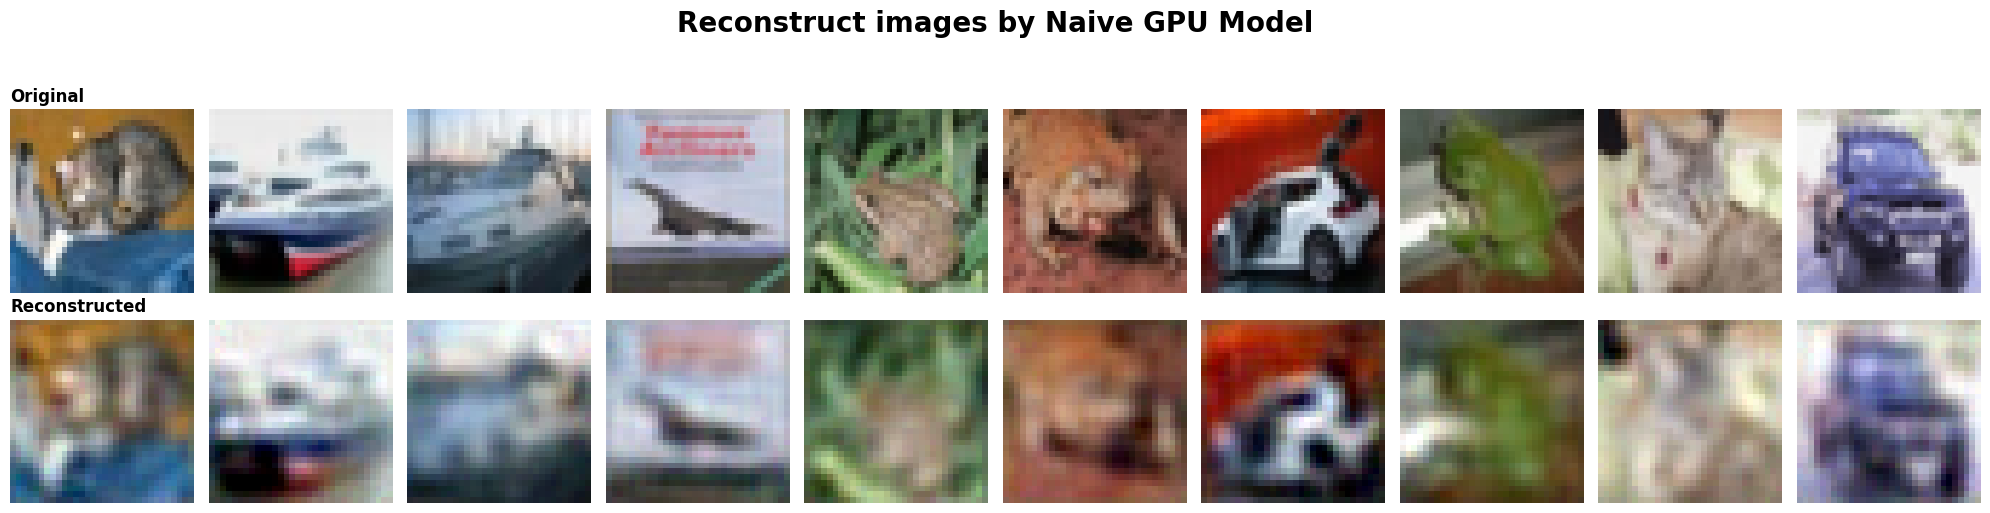

In [ ]:
base_path = "/content/ParallelProgramming_FinalProject/results/reconstruction_gpu_naive"
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
plt.suptitle("Reconstruct images by Naive GPU Model", fontsize=20, fontweight='bold', y=1.05)

for i in range(num_images):
    # Construct filenames
    orig_name = f"img_{i}_orig.ppm"
    recon_name = f"img_{i}_recon.ppm"

    # Open images
    orig_img = Image.open(os.path.join(base_path, orig_name))
    recon_img = Image.open(os.path.join(base_path, recon_name))

    # Plot Original
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Original", loc='left', fontweight='bold')

    # Plot Reconstructed
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Reconstructed", loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

### **4. Key Takeaways:**
Sau khi hoàn tất quá trình cài đặt và thực nghiệm, nhóm tiến hành so sánh hiệu năng giữa phiên bản Naive GPU và CPU Baseline, từ đó rút ra các nhận định chính sau:

- **Những điểm về hiệu năng**:
	- **Điểm nhanh hơn kỳ vọng:** Mặc dù chưa áp dụng các kỹ thuật tối ưu hóa nâng cao, phiên bản Naive GPU vẫn cho tốc độ huấn luyện nhanh hơn đáng kể so với việc thực hiện các vòng lặp tuần tự trên CPU. Điều này cho thấy việc song song hóa cơ bản đã mang lại lợi ích rõ rệt.
  - **Điểm chậm hơn mong đợi:** Một số kernel, đặc biệt là kernel tính hàm mất mát MSE, chưa đạt được hiệu năng tương xứng do phát sinh hiện tượng tuần tự hóa giữa các thread, làm giảm mức độ song song của GPU.
- **Các cơ hội tối ưu hóa**:
	- **Tối ưu truy cập bộ nhớ:** Các kernel hiện tại chủ yếu truy cập dữ liệu trực tiếp từ Global Memory, dẫn đến độ trễ lớn và làm giảm tốc độ tính toán. Việc khai thác Shared Memory có thể giúp giảm số lần truy cập bộ nhớ toàn cục.
  - **Khai thác hiệu quả bộ nhớ Constant:** Các tham số cố định của kernel (ví dụ: kích thước ảnh, số kênh, kích thước kernel) chưa được lưu trữ và cache trong Constant Memory, gây lãng phí băng thông đọc/ghi.
  - **Giảm hiện tượng serialization trong tính toán loss:** Việc tất cả các thread cùng gọi atomicAdd vào một biến loss duy nhất trong mse_loss_kernel gây ra nghẽn nghiêm trọng. Đây là vị trí tiềm năng để áp dụng các chiến lược giảm song song theo block (block-level reduction) nhằm cải thiện hiệu năng.

## **Phase 2.3: GPU Optimized Implementation - Version 1 - Memory Optimization**

### **1. Optimization Focus**

Ở version 1 này, nhóm tập trung vào việc tối bộ nhớ để có thể tăng tốc quá trình huấn luyện Autoencoder trên GPU. Và các kĩ thuật mà nhóm lựa chọn là:
- Shared Memory Tiling for Convolution
- Pinned (Page-Locked) Memory
- Constant Memory for Biases

### **2. Objectives**
- Mục tiêu của Phase 2.3 là giảm độ trễ truy cập bộ nhớ toàn cục (global memory latency) và tăng hiệu quả sử dụng băng thông bộ nhớ GPU trong quá trình huấn luyện Autoencoder. Cụ thể, nhóm tập trung vào:
  - Sử dụng `Shared Memory Tiling` để biến các truy cập lặp lại vào `Global Memory` thành các truy cập vào bộ nhớ `on-chip`, giúp giảm áp lực lên băng thông bộ nhớ của GPU.
  - Chuyển các tham số ít thay đổi nhưng được truy cập bởi toàn bộ thread (như Biases) vào `Constant Memory` để tận dụng cơ chế broadcast và bộ đệm cache chuyên biệt, giúp giảm độ trễ truy cập so với `Global Memory`.
  - Sử dụng Pinned (Page-Locked) Memory để cho phép bộ điều khiển  truyền dữ liệu trực tiếp giữa CPU và GPU.
- Kết quả mong đợi:
  - Giảm đáng kể thời gian thực thi của kernel Conv2D và tổng thời gian huấn luyện mỗi epoch.
  - Tăng throughput (images/sec)

### **3. Implementation Details**
#### **3.1 Shared memory tiling**
- Nhóm đã triển khai `shared memory tiling` cho giai đoạn forward (Conv2D) trong kiến trúc Autoencoder, nhằm giảm chi phí truy cập global memory.

- Trong cài đặt baseline, mỗi thread khi tính một phần tử output sẽ:
  - Đọc nhiều lần các phần tử input chồng lấn nhau
  - Truy cập global memory cho cùng một vùng dữ liệu nhiều lần giữa các thread lân cận

- Điều này dẫn đến:
  - Băng thông bộ nhớ thấp
  - Cache miss cao
  - Hiệu suất kernel bị giới hạn bởi memory bandwidth

- Và ý tưởng chính là  Kỹ thuật này chia không gian đầu ra ($H_{\text{out}} \times W_{\text{out}}$) thành các tile ($TILE\_SIZE \times TILE\_SIZE$). Mỗi block GPU được gán trách nhiệm tính toán một tile đầu ra. Để tính toán tile này, block cần một vùng dữ liệu Input lớn hơn một chút, bao gồm cả vùng biên (halo region).

- Kích thước Block (blockDim):
  - Sử dụng Block 3D: dim3 blockDim(1, TILE_SIZE, TILE_SIZE).
  - Các thread trong Block được tổ chức thành lưới $TILE\_SIZE \times TILE\_SIZE$ (theo chiều $y$ và $z$), mỗi thread sẽ chịu trách nhiệm tính toán một phần tử đầu ra ($O_{h,w}$) trong Tile. (Chiều $x$ luôn là 1).

- Kích thước Grid (gridDim):
  - Sử dụng Grid 3D: `dim3 gridDim(C_out, (H_out + TILE_SIZE - 1) / TILE_SIZE, (W_out + TILE_SIZE - 1) / TILE_SIZE)`.
  - $x$: Duyệt qua các kênh đầu ra ($C_{out}$). Mỗi Block tính toán một Tile đầu ra cho một kênh đầu ra.
  - $y$ và $z$: Duyệt qua các Tile của không gian đầu ra ($H_{out} \times W_{out}$).

- Kích thước Shared Memory:
  - Kích thước của lát đầu vào cần thiết cho một lát đầu ra $TILE\_SIZE \times TILE\_SIZE$ là: $SMEM\_H \times SMEM\_W$, với $SMEM\_H = TILE\_SIZE + K - 1$ và $SMEM\_W = TILE\_SIZE + K - 1$ (bao gồm cả vùng biên - halo region).
  - `smem_size = smem_h * smem_w * sizeof(float)`. Đây là kích thước Shared Memory động (extern __shared__) được truyền vào khi launch kernel.
- Key Code Snippets:
```cpp
for (int idx = tid; idx < smem_size; idx += threads_per_block) {
      int smem_h = idx / SMEM_W;
      int smem_w = idx % SMEM_W;
      
      int ih = tile_ih_start + smem_h;
      int iw = tile_iw_start + smem_w;
      
      float val = 0.0f;
      if (ih >= 0 && ih < H_in && iw >= 0 && iw < W_in) {
          val = input[ic * H_in * W_in + ih * W_in + iw];
      }
      smem[smem_h * SMEM_W + smem_w] = val;
  }
  
  __syncthreads();
  
  // Compute convolution using shared memory
  if (oh < H_out && ow < W_out) {
      for (int kh = 0; kh < kernel_size; kh++) {
          for (int kw = 0; kw < kernel_size; kw++) {
              // Position in shared memory
              int smem_h = ty * stride + kh;
              int smem_w = tz * stride + kw;
              
              float input_val = smem[smem_h * SMEM_W + smem_w];
              
              int weight_idx = ((oc * C_in + ic) * kernel_size + kh) * kernel_size + kw;
              sum += input_val * weight[weight_idx];
          }
      }
  }
```


#### **3.2 Pinned Memory**
- Nhóm nhận thấy trong quá trình huấn luyện Autoencoder, việc truyền dữ liệu hình ảnh từ CPU lên GPU diễn ra liên tục ở mỗi batch. Thông thường CUDA phải thực hiện một bước trung gian: sao chép dữ liệu từ `Pageable Host Memory` sang một vùng đệm trước khi nạp lên GPU, gây ra lãng phí tài nguyên và tăng độ trễ.
- Nhóm đã triển khai kỹ thuật `Pinned Memory (Page-Locked Memory)` bằng cách sử dụng `cudaMallocHost`. Vùng nhớ này được cố định trực tiếp vào bộ nhớ vật lý của hệ thống, cho phép bộ điều khiển truyền dữ liệu thẳng lên GPU mà không cần sự can thiệp của CPU hay bước đệm trung gian.
- Quy trình:
  1. Khởi tạo bằng `cudaMallocHost`
  2. Trong vòng lặp huấn luyện (train_step):
    - Dữ liệu thô từ `DataLoader` được `memcpy` vào vùng `h_input_pinned`
    - Thực hiện lệnh `cudaMemcpy` từ vùng `pinned` này lên `device`.
- Key code snippets:
```cpp
//...

// Allocate pinned memory for faster H2D transfers
CUDA_CHECK(cudaMallocHost(&h_input_pinned, INPUT_C * INPUT_H * INPUT_W * sizeof(float)));

//....
float AutoencoderGPUOptimized1::train_step(const float* input_chw, float learning_rate) {
    // Copy input to device using pinned memory (faster H2D transfer)
    int input_size = 3*32*32*sizeof(float);
    memcpy(h_input_pinned, input_chw, input_size);
    CUDA_CHECK(cudaMemcpy(d_input, h_input_pinned, input_size, cudaMemcpyHostToDevice));

    //...
}
```

#### **3.3  Constant Memory for Biases**
- Nhóm nhận thấy trong các phép toán Convolution, giá trị Bias có một đặc điểm rất đặc biệt vì:
  - Chúng là các giá trị chỉ đọc (read-only) trong suốt quá trình thực thi một kernel.
  - Tất cả các thread trong cùng một Warp khi tính toán các pixel khác nhau trên cùng một kênh đầu ra đều truy cập vào cùng một giá trị bias.

- Vì vậy, nếu để Bias ở Global Memory, mỗi thread sẽ phải thực hiện một lệnh đọc riêng biệt, gây lãng phí băng thông.

- Quy trình:
  1. Khai báo tĩnh các mảng bias để GPU cấp phát vùng nhớ cố định ngay khi chương trình khởi chạy.
  2. Sử dụng hàm `cudaMemcpyToSymbol` để nạp dữ liệu vào `Constant Memory`.
  3. Thay vì truyền con trỏ `float* bias` qua tham số hàm, kernel sẽ truy cập trực tiếp vào `c_conv_bias` từ `Constant Cache`.

```cpp
// Constant memory for biases (64KB available, plenty for all biases)
__constant__ float c_conv1_bias[256];
__constant__ float c_conv2_bias[128];
__constant__ float c_conv3_bias[128];
__constant__ float c_conv4_bias[256];
__constant__ float c_conv5_bias[3];

// Copy bias to constant memory for faster access
void copy_bias_to_constant_memory(
    const float* d_bias, int size, int layer)
{
    switch(layer) {
        case 0:  // Conv1: 256
            CUDA_CHECK(cudaMemcpyToSymbol(c_conv1_bias, d_bias, size * sizeof(float)));
            break;
        case 1:  // Conv2: 128
            CUDA_CHECK(cudaMemcpyToSymbol(c_conv2_bias, d_bias, size * sizeof(float)));
            break;
        case 2:  // Conv3: 128
            CUDA_CHECK(cudaMemcpyToSymbol(c_conv3_bias, d_bias, size * sizeof(float)));
            break;
        case 3:  // Conv4: 256
            CUDA_CHECK(cudaMemcpyToSymbol(c_conv4_bias, d_bias, size * sizeof(float)));
            break;
        case 4:  // Conv5: 3
            CUDA_CHECK(cudaMemcpyToSymbol(c_conv5_bias, d_bias, size * sizeof(float)));
            break;
        default:
            fprintf(stderr, "Invalid layer index: %d\n", layer);
    }
}
```



### **4. Results:**

Thực hiện train autoencoder với toàn bộ dữ liệu trên 10 epoch, batch_size = 64 và learning_rate = 0.001:

In [ ]:
!nvcc -arch=sm_75 src/main_phase3_1.cu build/cifar10_loader.o build/autoencoder_gpu_optimized_1.o build/gpu_kernels_naive.o build/gpu_kernels_optimized_1.o -o build/phase3_1

In [ ]:
!./build/phase3_1

Streaming output truncated to the last 5000 lines.
Batch [512/782] Avg Loss: 0.00617344
Batch [513/782] Avg Loss: 0.00545697
Batch [514/782] Avg Loss: 0.00612815
Batch [515/782] Avg Loss: 0.00687422
Batch [516/782] Avg Loss: 0.00652018
Batch [517/782] Avg Loss: 0.00650817
Batch [518/782] Avg Loss: 0.00686105
Batch [519/782] Avg Loss: 0.00668733
Batch [520/782] Avg Loss: 0.00629484
Batch [521/782] Avg Loss: 0.00606003
Batch [522/782] Avg Loss: 0.00613676
Batch [523/782] Avg Loss: 0.00631076
Batch [524/782] Avg Loss: 0.00530462
Batch [525/782] Avg Loss: 0.00661694
Batch [526/782] Avg Loss: 0.00703323
Batch [527/782] Avg Loss: 0.00618011
Batch [528/782] Avg Loss: 0.00724683
Batch [529/782] Avg Loss: 0.00669812
Batch [530/782] Avg Loss: 0.00680128
Batch [531/782] Avg Loss: 0.00669218
Batch [532/782] Avg Loss: 0.00646411
Batch [533/782] Avg Loss: 0.00681557
Batch [534/782] Avg Loss: 0.00724172
Batch [535/782] Avg Loss: 0.00627741
Batch [536/782] Avg Loss: 0.00659533
Batch [537/782] Avg Loss

Chạy nsys để kiểm tra thông số GPU khi train mô hình (Ở đây nhóm sẽ chạy nsys trong 1 epoch, vì nsys không thể tải thông tin train của toàn bộ 10 epoch được).

In [ ]:
!nsys profile --stats=true --output=report_output ./build/phase3_1

PHASE 3.1: Optimized GPU version 1

=== Loading CIFAR-10 Dataset ===
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000

Dataset loaded successfully!
Training images: 50000
Test images: 10000

=== Training GPU Autoencoder (optimized) ===
Full training with 50000 images, 1 epochs
GPU weights initialized

Epoch 1/1
Batch [1/782] Avg Loss: 0.14364
Batch [2/782] Avg Loss: 0.0757077
Batch [3/782] Avg Loss: 0.0525987
Batch [4/782] Avg Loss: 0.0487857
Batch [5/782] Avg Loss: 0.0441823
Batch [6/782] Avg Loss: 0.0398327
Batch [7/782] Avg Loss: 0.0378032
Batch [8/782] Avg Loss: 0.0379359
Batch [9/782] Avg Loss: 0.0297523
Batch [10/782] Avg Loss: 0.0332329
Batch [11/782] Avg Loss: 0.0303164
Batch [12/782] Avg Loss: 0.0266328
Batch [13/782] Avg Loss: 0.0291286
Batch [14/782] Avg Loss: 0.0300002
Batch [15/782] Avg Loss: 0

Reconstruct 10 ảnh trong tập test để kiểm tra độ chính xác của Autoencoder

In [ ]:
!./build/reconstruct gpu_opt1 10

CIFAR-10 Autoencoder Reconstruction

Loading CIFAR-10 dataset...
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000
Dataset loaded: 10000 test images

Loading weights from: weights/autoencoder_gpu_optimized_1.bin
Starting reconstruction loop...
GPU weights initialized
Weights loaded from weights/autoencoder_gpu_optimized_1.bin
  Finished image 1/10
  Finished image 2/10
  Finished image 3/10
  Finished image 4/10
  Finished image 5/10
  Finished image 6/10
  Finished image 7/10
  Finished image 8/10
  Finished image 9/10
  Finished image 10/10

Success! Images are saved in: results/reconstruction_gpu_opt1


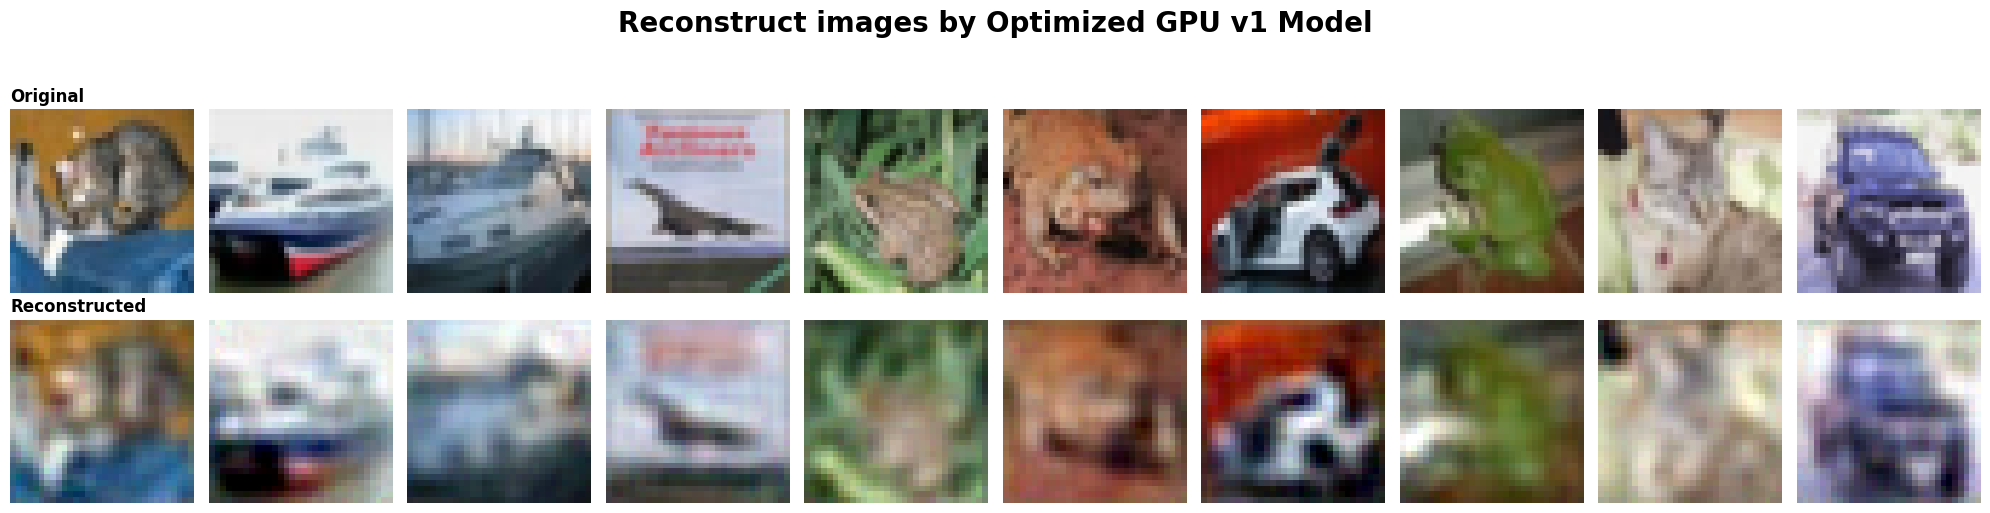

In [ ]:
base_path = "/content/ParallelProgramming_FinalProject/results/reconstruction_gpu_opt1"
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
plt.suptitle("Reconstruct images by Optimized GPU v1 Model", fontsize=20, fontweight='bold', y=1.05)

for i in range(num_images):
    # Construct filenames
    orig_name = f"img_{i}_orig.ppm"
    recon_name = f"img_{i}_recon.ppm"

    # Open images
    orig_img = Image.open(os.path.join(base_path, orig_name))
    recon_img = Image.open(os.path.join(base_path, recon_name))

    # Plot Original
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Original", loc='left', fontweight='bold')

    # Plot Reconstructed
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Reconstructed", loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

### **5. Key Takeaways**
- **Bài học rút ra từ quá trình tối ưu hóa:** Sau khi triển khai phiên bản tối ưu hóa bộ nhớ (Version 1), nhóm đã đúc kết được các bài học cốt lõi trong lập trình GPU hiệu năng cao:
  - Hiệu suất của Autoencoder trên GPU không chỉ nằm ở tốc độ tính toán mà nằm ở khả năng quản lý luồng dữ liệu. Việc kết hợp Pinned (Host), Constant (Cache) và Shared Memory (On-chip) tạo ra một pipeline dữ liệu thông suốt, giảm thiểu thời gian nhàn rỗi của các kernel.
  - `Shared Memory Tiling` giúp giải quyết triệt để vấn đề lãng phí băng thông do việc đọc lặp lại các vùng biên (halo region) trong tích chập.
  - Việc sử dụng `Shared Memory` và `Constant Memory` đòi hỏi sự tính toán kỹ lưỡng về tài nguyên.
- **Khả năng áp dụng cho các bài toán khác:** Các kỹ thuật tối ưu hóa bộ nhớ trong Version 1 này không chỉ giới hạn ở Autoencoder mà có tính ứng dụng rất cao cho nhiều bài toán thực tế khác:
  - Kỹ thuật `Shared Memory Tiling` có thể áp dụng hiệu quả cho nhiều bài toán xử lý ảnh và tín hiệu, chẳng hạn như các bộ lọc làm mờ (Gaussian blur), làm nét ảnh, hoặc các phép toán yêu cầu tái sử dụng thường xuyên dữ liệu lân cận.
  - `Constant Memory` phù hợp để lưu trữ các tham số cố định hoặc ít thay đổi, như trọng số và bias của mô hình đã huấn luyện, giúp giảm chi phí truy cập bộ nhớ toàn cục trong nhiều mô hình học sâu và thuật toán song song khác.

## **Phase 2.4: GPU Optimized Implementation - Version 2 - Kernel-Level Optimization**

### **1. Optimization Focus**
Ở version 2 này, nhóm tập trung vào việc tối ưu Kernel-block để có thể tăng tốc quá trình huấn luyện Autoencoder trên GPU. Và hai kĩ thuật mà nhóm lựa chọn là:
- Kernel Fusion (Conv + ReLU + Bias)
- Loop Unrolling

### **2. Objectives**
- Với việc hợp nhất Kernel, nhóm mong muốn **giảm overhead** khởi tạo kernel và tăng tính cục bộ dữ liệu bằng cách gộp các phép toán đơn giản.
- Cho các vòng lặp nhỏ (Kernel Size = 3) để giảm overhead của Branching (lệnh rẽ nhánh) và tăng cường Instruction-Level Parallelism.

### **3. Implementation Details**

- **Đối với Kernel Fusing**
  - Gộp hàm Activation (ReLU) vào Kernel tính toán chính (Convolution) cho giai đoạn Forward.
  - Điều này sẽ giúp loại bỏ 1 kernel launch. Dữ liệu tính toán Conv/Grad_Conv không cần phải ghi ra `global memory` rồi đọc lại ngay lập tức cho `ReLU/Grad_ReLU`, giúp tăng tốc độ truy cập và giảm băng thông bộ nhớ.
- **Đối với Loop Unrolling**
  - Nhóm triển khai trên 3 kernel Convolution đã được hợp nhất ReLU ở cả giai đoạn forward bằng `#pragma unroll` cho các vòng lặp Kernel Size $3\times3$.
  - Đồng thời những hàm kernel có kích thước `pool_size` cũng tích hợp unroll looping thủ công.
  - Với những Kernel kích thước nhỏ, việc này giúp làm giảm đi các lệnh rẽ nhánh và kiểm tra điều kiện. Chắc chắn tối đa được tốc độ.

### **4. Key Code Snippets**

- Đối với `Fused Conv-ReLU Forward`

```cpp
// Fused convolution with loop unrolling for kernel_size=3
if (kernel_size == 3){
    for (int ic = 0; ic < in_c; ++ic) {
        #pragma unroll // Unroll cho kh
        for (int kh = 0; kh < 3; ++kh) {
            // ... (Kiểm tra biên ih) ...
            #pragma unroll // Unroll cho kw
            for (int kw = 0; kw < 3; ++kw) {
                // ... (Tính toán và tích lũy sum) ...
            }
        }
    }
}
// ... Fused ReLU activation: max(0, sum)
output[idx] = fmaxf(0.0f, sum);
```

- Đối với `max_pooling`
```cpp
int ih0 = ih_start;
int iw0 = iw_start;
if (ih0 < H && iw0 < W) {
    float val = input[c * H * W + ih0 * W + iw0];
    max_val = fmaxf(max_val, val);
}

int iw1 = iw_start + 1;
if (ih0 < H && iw1 < W) {
    float val = input[c * H * W + ih0 * W + iw1];
    max_val = fmaxf(max_val, val);
}

int ih1 = ih_start + 1;
if (ih1 < H && iw0 < W) {
    float val = input[c * H * W + ih1 * W + iw0];
    max_val = fmaxf(max_val, val);
}

if (ih1 < H && iw1 < W) {
    float val = input[c * H * W + ih1 * W + iw1];
    max_val = fmaxf(max_val, val);
}

output[c * H_out * W_out + oh * W_out + ow] = max_val;
```



### **5. Result:**

Thực hiện train autoencoder với toàn bộ dữ liệu trên 10 epoch, batch_size = 64 và learning_rate = 0.001:

In [ ]:
!nvcc -arch=sm_75 src/main_phase3_2.cu build/cifar10_loader.o build/autoencoder_gpu_optimized_2.o build/gpu_kernels_naive.o build/gpu_kernels_optimized_2.o -o build/phase3_2

In [ ]:
!./build/phase3_2

Streaming output truncated to the last 5000 lines.
Batch [512/782] Avg Loss: 0.00668233
Batch [513/782] Avg Loss: 0.00594221
Batch [514/782] Avg Loss: 0.00663413
Batch [515/782] Avg Loss: 0.00739708
Batch [516/782] Avg Loss: 0.00703226
Batch [517/782] Avg Loss: 0.0069365
Batch [518/782] Avg Loss: 0.00741475
Batch [519/782] Avg Loss: 0.00718987
Batch [520/782] Avg Loss: 0.00670349
Batch [521/782] Avg Loss: 0.00659302
Batch [522/782] Avg Loss: 0.00653779
Batch [523/782] Avg Loss: 0.00680557
Batch [524/782] Avg Loss: 0.00573855
Batch [525/782] Avg Loss: 0.00707346
Batch [526/782] Avg Loss: 0.00763846
Batch [527/782] Avg Loss: 0.00674146
Batch [528/782] Avg Loss: 0.00770632
Batch [529/782] Avg Loss: 0.00726591
Batch [530/782] Avg Loss: 0.00725882
Batch [531/782] Avg Loss: 0.00718198
Batch [532/782] Avg Loss: 0.0070073
Batch [533/782] Avg Loss: 0.00728397
Batch [534/782] Avg Loss: 0.00771446
Batch [535/782] Avg Loss: 0.00681445
Batch [536/782] Avg Loss: 0.0071247
Batch [537/782] Avg Loss: 0

Chạy nsys để kiểm tra thông số GPU khi train mô hình (Ở đây nhóm sẽ chạy nsys trong 1 epoch, vì nsys không thể tải thông tin train của toàn bộ 10 epoch được).

In [ ]:
!nsys profile --stats=true --output=report_output ./build/phase3_2

PHASE 3.2:  Optimized GPU version 2

=== Loading CIFAR-10 Dataset ===
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000

Dataset loaded successfully!
Training images: 50000
Test images: 10000

=== Training GPU Autoencoder (optimized) ===
Full training with 50000 images, 1 epochs
GPU weights initialized

Epoch 1/1
Batch [1/782] Avg Loss: 0.145463
Batch [2/782] Avg Loss: 0.0777173
Batch [3/782] Avg Loss: 0.0540876
Batch [4/782] Avg Loss: 0.0503207
Batch [5/782] Avg Loss: 0.0457722
Batch [6/782] Avg Loss: 0.0411967
Batch [7/782] Avg Loss: 0.0391679
Batch [8/782] Avg Loss: 0.0392908
Batch [9/782] Avg Loss: 0.030818
Batch [10/782] Avg Loss: 0.0345295
Batch [11/782] Avg Loss: 0.0312584
Batch [12/782] Avg Loss: 0.0278938
Batch [13/782] Avg Loss: 0.0304094
Batch [14/782] Avg Loss: 0.0309553
Batch [15/782] Avg Loss: 

Reconstruct 10 ảnh trong tập test để kiểm tra độ chính xác của Autoencoder

In [ ]:
!./build/reconstruct gpu_opt2 10

CIFAR-10 Autoencoder Reconstruction

Loading CIFAR-10 dataset...
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000
Dataset loaded: 10000 test images

Loading weights from: weights/autoencoder_gpu_optimized_2.bin
Starting reconstruction loop...
GPU weights initialized
Weights loaded from weights/autoencoder_gpu_optimized_2.bin
  Finished image 1/10
  Finished image 2/10
  Finished image 3/10
  Finished image 4/10
  Finished image 5/10
  Finished image 6/10
  Finished image 7/10
  Finished image 8/10
  Finished image 9/10
  Finished image 10/10

Success! Images are saved in: results/reconstruction_gpu_opt2


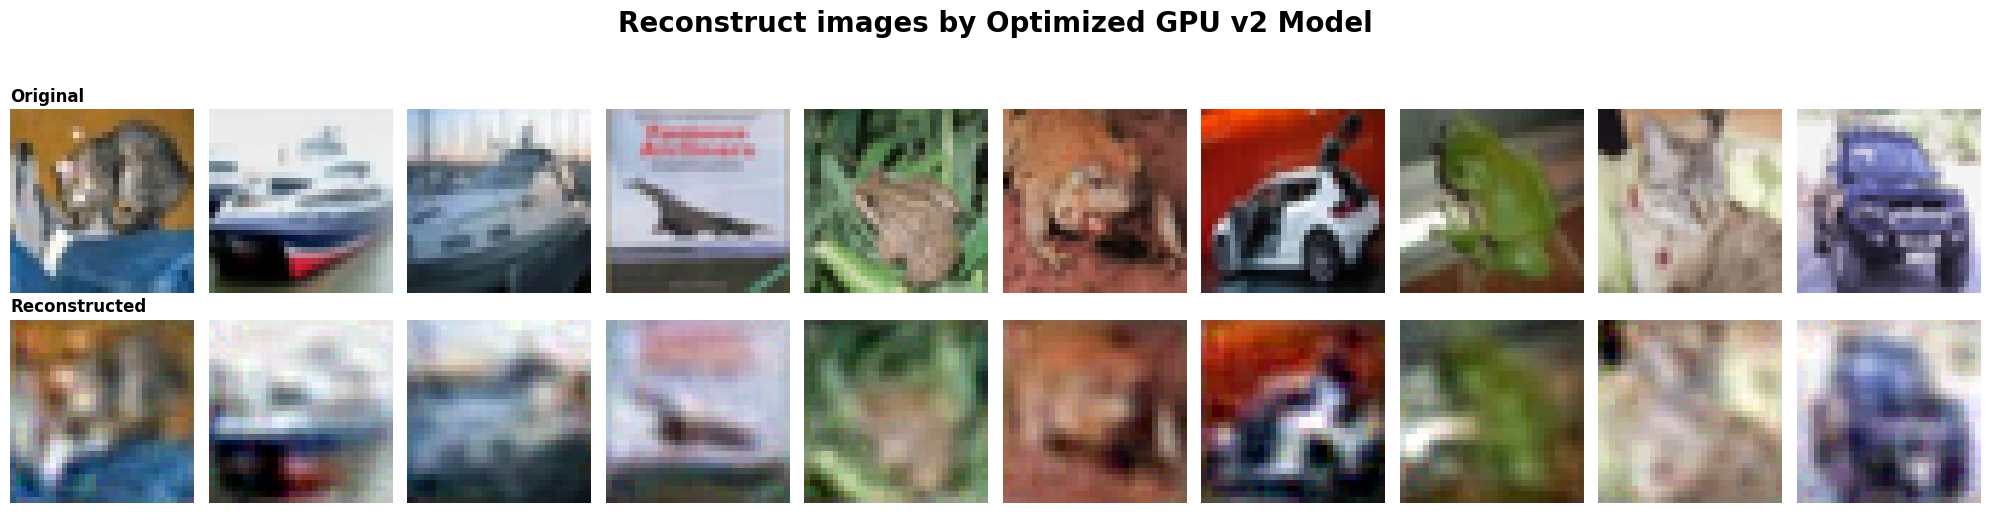

In [ ]:
base_path = "/content/ParallelProgramming_FinalProject/results/reconstruction_gpu_opt2"
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
plt.suptitle("Reconstruct images by Optimized GPU v2 Model", fontsize=20, fontweight='bold', y=1.05)

for i in range(num_images):
    # Construct filenames
    orig_name = f"img_{i}_orig.ppm"
    recon_name = f"img_{i}_recon.ppm"

    # Open images
    orig_img = Image.open(os.path.join(base_path, orig_name))
    recon_img = Image.open(os.path.join(base_path, recon_name))

    # Plot Original
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Original", loc='left', fontweight='bold')

    # Plot Reconstructed
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Reconstructed", loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

### **6. Key Takeaways**
- **Bài học rút ra từ quá trình tối ưu hóa:** Sau khi triển khai phiên bản tối ưu Kernel-block (Version 2), nhóm đã đúc kết được các bài học cốt lõi trong lập trình GPU hiệu năng cao:
  - **Kernel Fusing** là chiến lược tối ưu hóa quan trọng, trong đó các phép toán đơn giản được hợp nhất trực tiếp vào kernel liền kề. Cách tiếp cận này giúp giảm số lần truy cập bộ nhớ trung gian cũng như chi phí phát sinh do kernel launch, từ đó cải thiện hiệu năng tổng thể.
  - **Khử vòng lặp (Loop Unrolling)** là một kỹ thuật tối ưu hóa tương đối đơn giản, an toàn và mang lại hiệu quả rõ rệt. Việc giảm số lượng vòng lặp giúp tăng mức độ song song ở cấp lệnh (Instruction-Level Parallelism), đồng thời giảm overhead của các câu lệnh điều khiển.
- **Khả năng áp dụng cho các bài toán khác:** Các kỹ thuật tối ưu hóa trong Version 2 có tính ứng dụng rất cao cho nhiều bài toán thực tế khác:
  - **Kernel Fusing** có thể áp dụng rộng rãi cho nhiều kiến trúc mạng nơ-ron khác nhau, đặc biệt trong các trường hợp mà các hàm kích hoạt (Activation Functions) luôn được sử dụng ngay sau các lớp Convolution hoặc Fully Connected.
  - **Loop Unrolling** phù hợp cho các phép toán có kích thước kernel cố định và nhỏ, nơi số vòng lặp được xác định trước, giúp khai thác tối đa khả năng tối ưu của trình biên dịch và phần cứng GPU.

## **Phase 2.5: SVM Integration**

### **1. Objectives:**
Mục tiêu của giai đoạn này là:
- Trích xuất đặc trưng (feature extraction) từ dữ liệu đầu vào bằng encoder đã được huấn luyện của mô hình Autoencoder.
- Huấn luyện bộ phân loại SVM dựa trên các đặc trưng đã học, nhằm đánh giá khả năng phân biệt của không gian đặc trưng.
- Đánh giá hiệu năng phân loại của toàn bộ hệ thống theo hướng end-to-end, từ bước trích xuất đặc trưng đến kết quả dự đoán cuối cùng.

### **2. Implementation Details:**
#### **2.1. Feature Extraction**

- Sau khi huấn luyện Autoencoder, nhóm sử dụng **encoder đã được huấn luyện** để trích xuất đặc trưng cho từng ảnh trong tập CIFAR-10.
- Quá trình trích xuất được thực hiện tách biệt hoàn toàn với bước huấn luyện SVM nhằm giảm chi phí tính toán lặp lại.
- Với mỗi ảnh đầu vào (kích thước ($3 \times 32 \times 32$)), encoder sinh ra một vector đặc trưng có kích thước cố định (latent feature vector).
- Việc trích xuất được thực hiện theo từng ảnh (per-image API) cho cả phiên bản CPU và GPU:
  - CPU sử dụng hàm `extract_features` trên toàn bộ batch.
  - Các phiên bản GPU (naive và optimized) gọi kernel CUDA cho từng ảnh và ghi trực tiếp đặc trưng vào bộ nhớ host.
- Các đặc trưng sau khi trích xuất được lưu ra file nhị phân (`.bin`) cùng với metadata (số mẫu, số chiều đặc trưng), giúp thuận tiện cho việc nạp lại và huấn luyện SVM ở các bước sau.

#### **2.2. SVM Integration (cuML-based)**
- Thay vì sử dụng LIBSVM, nhóm sử dụng **cuML SVM (cuml.svm.SVC)** nhằm tận dụng tốc độ huấn luyện nhanh trên GPU.
- Các vector đặc trưng sau khi trích xuất được chuyển sang định dạng phù hợp với cuML thông qua **CuPy**, cho phép toàn bộ quá trình huấn luyện và suy luận SVM diễn ra trên GPU.
- Việc đánh giá mô hình sử dụng **confusion matrix**, ưu tiên phiên bản GPU (`cuml.metrics.confusion_matrix`) nếu khả dụng, và tự động fallback sang `sklearn` để đảm bảo tính tương thích.
- Cách tiếp cận này giúp loại bỏ overhead sao chép dữ liệu giữa CPU và GPU, đồng thời tận dụng tối đa tài nguyên GPU cho bài toán phân loại.

#### **2.3. Hyperparameter Selection**
- Nhóm sử dụng các siêu tham số chuẩn của SVM nhằm cân bằng giữa độ chính xác và chi phí tính toán:
  - **Kernel**: được lựa chọn tùy theo thí nghiệm (ví dụ: RBF hoặc Linear) để đánh giá khả năng phân tách của không gian đặc trưng.
  - **C**: hệ số regularization, điều chỉnh mức độ đánh đổi giữa biên phân cách và lỗi huấn luyện.
  - **Gamma**: tham số của kernel RBF, kiểm soát mức độ ảnh hưởng của từng điểm dữ liệu.
- Để tăng hiệu năng huấn luyện, tham số `cache_size` được đặt ở mức cao (2GB) nhằm tận dụng bộ nhớ GPU, giúp giảm thời gian truy cập dữ liệu trong quá trình tối ưu.
- Số vòng lặp tối đa (`max_iter`) và ngưỡng hội tụ (`tol`) được giới hạn để đảm bảo thời gian huấn luyện phù hợp cho thực nghiệm.


### **3. Results:**

Nhóm sử dụng thư viện cuML kết hợp với GPU Tesla T4 trên nền tảng Google Colab để triển khai và thực hiện giai đoạn này.

In [1]:
# Nếu đã thực hiện ở phần trên rồi thì có thể comment/không chạy cell này
import os
!git clone https://github.com/hahuy2004/ParallelProgramming_FinalProject.git
%cd ParallelProgramming_FinalProject

Cloning into 'ParallelProgramming_FinalProject'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 610 (delta 63), reused 67 (delta 30), pack-reused 485 (from 1)
Receiving objects: 100% (610/610), 23.28 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/ParallelProgramming_FinalProject


In [2]:
%cd /content/ParallelProgramming_FinalProject
# !mkdir -p build
!nvcc -arch=sm_75 -c src/cifar10_loader.cu -o build/cifar10_loader.o
!nvcc -arch=sm_75 -c src/autoencoder_cpu.cu -o build/autoencoder_cpu.o
!nvcc -arch=sm_75 -c src/autoencoder_gpu.cu -o build/autoencoder_gpu.o
!nvcc -arch=sm_75 -c src/autoencoder_gpu_optimized_1.cu -o build/autoencoder_gpu_optimized_1.o
!nvcc -arch=sm_75 -c src/autoencoder_gpu_optimized_2.cu -o build/autoencoder_gpu_optimized_2.o
!nvcc -arch=sm_75 -c cuda/gpu_kernels_naive.cu -o build/gpu_kernels_naive.o
!nvcc -arch=sm_75 -c cuda/gpu_kernels_optimized_1.cu -o build/gpu_kernels_optimized_1.o
!nvcc -arch=sm_75 -c cuda/gpu_kernels_optimized_2.cu -o build/gpu_kernels_optimized_2.o

/content/ParallelProgramming_FinalProject


In [3]:
%cd /content/ParallelProgramming_FinalProject
!nvcc -arch=sm_75 src/main_phase4_extract_features.cu build/cifar10_loader.o build/autoencoder_cpu.o build/autoencoder_gpu.o build/autoencoder_gpu_optimized_1.o build/autoencoder_gpu_optimized_2.o build/gpu_kernels_naive.o build/gpu_kernels_optimized_1.o build/gpu_kernels_optimized_2.o -o build/phase4_extract_features

/content/ParallelProgramming_FinalProject


In [4]:
%cd /content/ParallelProgramming_FinalProject
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -xzf cifar-10-binary.tar.gz

/content/ParallelProgramming_FinalProject
--2025-12-27 05:48:20--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘cifar-10-binary.tar.gz’

cifar-10-binary.tar 100%[===================>] 162.17M  36.4MB/s    in 4.8s    

2025-12-27 05:48:25 (33.8 MB/s) - ‘cifar-10-binary.tar.gz’ saved [170052171/170052171]



In [5]:
%cd /content/ParallelProgramming_FinalProject
!./build/phase4_extract_features --mode gpu_naive

/content/ParallelProgramming_FinalProject
PHASE 4: Extract Features (Single Model)
Mode: gpu_naive

=== Loading CIFAR-10 Dataset ===
Loading CIFAR-10 dataset from cifar-10-batches-bin
Loaded training batch 1
Loaded training batch 2
Loaded training batch 3
Loaded training batch 4
Loaded training batch 5
Loaded test batch
Training images: 50000
Test images: 10000
Training images: 50000
Test images: 10000

=== Extraction Summary ===
Mode: gpu_naive
Training samples: 50000
Test samples: 10000
Feature dimension: 8192
Output directory: features/gpu_naive

=== Extracting Features: gpu_naive ===
Weights: weights/autoencoder_gpu_naive.bin
Output directory: features/gpu_naive
GPU weights initialized
Weights loaded from weights/autoencoder_gpu_naive.bin
Extracting training features...
  Processed 50000/50000 images
Extracting test features...
  Processed 10000/10000 images
Feature extraction completed in 61.8253 seconds
Saved: features/gpu_naive/train_features.bin (50000 samples, 8192 dims)
Saved

In [6]:
#!/usr/bin/env python3
"""
PHASE 4: SVM Classification using cuML
Optimized for Tesla T4 GPU:
- Fast I/O using np.fromfile
- Batch inference to prevent VRAM OOM
- Aggressive RAM cleanup
- Vectorized Confusion Matrix calculation
"""

import os
import sys
import numpy as np
import time
import struct
import gc  # Garbage Collector để dọn RAM

# Kiểm tra và import thư viện GPU
try:
    from cuml.svm import SVC
    # Thử import confusion_matrix từ cuml, nếu không có thì dùng sklearn (để tương thích ngược)
    try:
        from cuml.metrics import confusion_matrix
        USE_CUML_CM = True
    except ImportError:
        from sklearn.metrics import confusion_matrix
        USE_CUML_CM = False

    import cupy as cp
    CUML_AVAILABLE = True
    print(f"cuML Available. Using GPU-accelerated Confusion Matrix: {USE_CUML_CM}")
except ImportError:
    print("Warning: cuML not available. Please install cuML.")
    sys.exit(1)

# CIFAR-10 class names
CLASS_NAMES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def load_features(filepath):
    """
    Tối ưu hóa: Đọc trực tiếp binary block vào NumPy array (nhanh gấp 100 lần struct).
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Feature file not found: {filepath}")

    with open(filepath, 'rb') as f:
        # Đọc header (2 số integer = 8 bytes)
        header = f.read(8)
        num_images = struct.unpack('i', header[:4])[0]
        feature_dim = struct.unpack('i', header[4:8])[0]

        # Đọc toàn bộ mảng float trong 1 lần đọc
        # count = số lượng phần tử float cần đọc
        features = np.fromfile(f, dtype=np.float32, count=num_images * feature_dim)
        features = features.reshape(num_images, feature_dim)

    print(f"Loaded {filepath}:")
    print(f"  - Samples: {num_images}")
    print(f"  - Feature dimension: {feature_dim}")

    return features, num_images, feature_dim

def load_labels(data_dir, is_train=True):
    """
    Load label CIFAR-10, dùng seek để nhảy qua dữ liệu ảnh (nhanh hơn read).
    """
    labels = []
    if is_train:
        # Load 5 training batches
        for i in range(1, 6):
            batch_file = os.path.join(data_dir, f"data_batch_{i}.bin")
            if not os.path.exists(batch_file):
                raise FileNotFoundError(f"Training batch not found: {batch_file}")

            with open(batch_file, 'rb') as f:
                for _ in range(10000):
                    labels.append(struct.unpack('B', f.read(1))[0])
                    f.seek(3072, 1) # Nhảy qua 3072 bytes ảnh
    else:
        # Load test batch
        test_file = os.path.join(data_dir, "test_batch.bin")
        if not os.path.exists(test_file):
            raise FileNotFoundError(f"Test batch not found: {test_file}")

        with open(test_file, 'rb') as f:
            for _ in range(10000):
                labels.append(struct.unpack('B', f.read(1))[0])
                f.seek(3072, 1)

    return np.array(labels, dtype=np.int32)

def print_confusion_matrix(cm, class_names):
    """In Confusion Matrix đẹp."""
    print("\n=== Confusion Matrix ===")
    print(f"{'':>12}", end='')
    for name in class_names:
        print(f"{name[:10]:>12}", end='')
    print()

    for i, name in enumerate(class_names):
        print(f"{name[:10]:>12}", end='')
        for j in range(len(class_names)):
            print(f"{cm[i, j]:>12}", end='')
        print()

def print_per_class_accuracy(cm, class_names):
    """In độ chính xác từng lớp."""
    print("\n=== Per-Class Accuracy ===")
    for i, name in enumerate(class_names):
        total = cm[i].sum()
        if total > 0:
            acc = 100.0 * cm[i, i] / total
            print(f"{name:>15}: {acc:>6.2f}%")
        else:
            print(f"{name:>15}: N/A")

def predict_in_batches(model, X_gpu, batch_size=4096):
    """
    Dự đoán theo lô (batch) để tránh tràn VRAM GPU và RAM CPU.
    """
    num_samples = X_gpu.shape[0]
    predictions = []

    # Dự đoán từng phần
    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)

        # Lấy slice trực tiếp trên GPU (không copy về CPU)
        batch_X = X_gpu[i:end_idx]

        # Predict trả về array (có thể là cupy hoặc numpy tùy version cuml)
        batch_pred = model.predict(batch_X)

        predictions.append(batch_pred)

        # Clean up
        del batch_X

    # Nối các mảng lại (dùng thư viện phù hợp dựa trên kiểu dữ liệu trả về)
    if len(predictions) > 0:
        if isinstance(predictions[0], cp.ndarray):
            return cp.concatenate(predictions)
        else:
            return np.concatenate(predictions)
    return np.array([])

def train_and_evaluate_svm(train_features, train_labels, test_features, test_labels,
                           C=1.0, kernel='rbf', gamma='scale', save_path=None):

    print("\n=== Step 1: Preparing Data for GPU ===")
    start_transfer = time.time()

    # 1. Chuyển Training Data lên GPU
    print("Moving Training Data to GPU...")
    X_train_gpu = cp.asarray(train_features, dtype=cp.float32)
    y_train_gpu = cp.asarray(train_labels, dtype=cp.int32)

    # [QUAN TRỌNG] Xóa ngay dữ liệu gốc trên RAM CPU để giải phóng bộ nhớ
    del train_features, train_labels
    gc.collect()

    # 2. Chuyển Test Data lên GPU
    print("Moving Test Data to GPU...")
    X_test_gpu = cp.asarray(test_features, dtype=cp.float32)
    y_test_gpu = cp.asarray(test_labels, dtype=cp.int32)

    # [QUAN TRỌNG] Xóa tiếp
    del test_features, test_labels
    gc.collect()

    transfer_time = time.time() - start_transfer
    print(f"Data transfer & Cleanup time: {transfer_time:.4f} seconds")
    print(f"Training set shape (GPU): {X_train_gpu.shape}")

    # Initialize SVM
    print(f"\n=== Step 2: Training SVM ===")
    print(f"Kernel: {kernel}, C: {C}, Gamma: {gamma}")

    # cache_size=2000 (2GB) để tận dụng RAM GPU, giúp train nhanh hơn
    svm = SVC(C=C, kernel=kernel, gamma=gamma, cache_size=2000, max_iter=100, tol=1e-3, verbose=True)

    train_start = time.time()
    svm.fit(X_train_gpu, y_train_gpu)
    train_time = time.time() - train_start
    print(f"Training completed in {train_time:.4f} seconds")

    # Evaluate on training set
    print("\n=== Step 3: Evaluating on Training Set (Batched) ===")
    train_pred_start = time.time()

    # Dùng hàm batch để không bị OOM
    train_predictions = predict_in_batches(svm, X_train_gpu, batch_size=4096)

    # Nếu kết quả là numpy array (do version cũ), chuyển sang cupy để tính toán nhanh
    if not isinstance(train_predictions, cp.ndarray):
        train_predictions = cp.asarray(train_predictions)

    train_accuracy = cp.mean(train_predictions == y_train_gpu) * 100
    train_pred_time = time.time() - train_pred_start

    print(f"Training accuracy: {train_accuracy:.2f}%")
    print(f"Training prediction time: {train_pred_time:.4f} seconds")

    # Evaluate on test set
    print("\n=== Step 4: Evaluating on Test Set (Batched) ===")
    test_pred_start = time.time()

    test_predictions = predict_in_batches(svm, X_test_gpu, batch_size=4096)

    if not isinstance(test_predictions, cp.ndarray):
        test_predictions = cp.asarray(test_predictions)

    test_accuracy = cp.mean(test_predictions == y_test_gpu) * 100
    test_pred_time = time.time() - test_pred_start

    print(f"Test accuracy: {test_accuracy:.2f}%")
    print(f"Test prediction time: {test_pred_time:.4f} seconds")

    # Confusion Matrix Optimization
    print("\n=== Computing Confusion Matrix ===")
    if USE_CUML_CM:
        # Tính trực tiếp trên GPU
        cm_gpu = confusion_matrix(y_test_gpu, test_predictions)
        # Chuyển kết quả (chỉ 10x10) về CPU để in
        cm = cp.asnumpy(cm_gpu)
    else:
        # Fallback về sklearn (CPU) nếu cuML lỗi, nhưng cần chuyển dữ liệu về CPU trước
        y_test_cpu = cp.asnumpy(y_test_gpu)
        test_pred_cpu = cp.asnumpy(test_predictions)
        cm = confusion_matrix(y_test_cpu, test_pred_cpu)

    print_confusion_matrix(cm, CLASS_NAMES)
    print_per_class_accuracy(cm, CLASS_NAMES)

    # Save model nếu được yêu cầu
    if save_path:
        print(f"\n=== Saving Model ===")
        # Note: cuML models can be saved using pickle or joblib
        import pickle
        with open(save_path, 'wb') as f:
            pickle.dump(svm, f)
        print(f"Model saved to: {save_path}")

    # Summary
    print("\n" + "=" * 50)
    print("=== SUMMARY ===")
    print("=" * 50)
    print(f"Data transfer time:       {transfer_time:.4f}s")
    print(f"Training time:            {train_time:.4f}s")
    print(f"Training prediction time: {train_pred_time:.4f}s")
    print(f"Test prediction time:     {test_pred_time:.4f}s")
    print(f"Total time:               {transfer_time + train_time + train_pred_time + test_pred_time:.4f}s")
    print(f"\nTraining accuracy:        {train_accuracy:.2f}%")
    print(f"Test accuracy:            {test_accuracy:.2f}%")
    print("=" * 50)

    return svm, test_accuracy

def main():
    # Hardcoded parameters
    mode = 'gpu_naive'
    data_dir = 'cifar-10-batches-bin'
    # Thay thế bằng đường dẫn tới thư mục features đúng
    features_base_dir = '/content/ParallelProgramming_FinalProject/features'
    kernel = 'rbf'
    C = 1.0
    gamma = 'scale'
    # save_model = "/content/ParallelProgramming_FinalProject/weights/svm_cuml.pkl"
    save_model = None # Nếu không cần save model thì sẽ uncomment này

    print("=" * 60)
    print("PHASE 4: SVM Classification (Optimized for T4)")
    print("=" * 60)

    feature_dir = os.path.join(features_base_dir, mode)
    train_feature_path = os.path.join(feature_dir, 'train_features.bin')
    test_feature_path = os.path.join(feature_dir, 'test_features.bin')

    # Load Features
    print(f"\n=== Loading Features ===")
    try:
        train_features, num_train, train_dim = load_features(train_feature_path)
        test_features, num_test, test_dim = load_features(test_feature_path)

        # Kiểm tra sanity
        if train_dim != test_dim:
            raise ValueError(f"Mismatch dim: train={train_dim}, test={test_dim}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        sys.exit(1)

    # Load Labels
    print(f"\n=== Loading Labels ===")
    try:
        train_labels = load_labels(data_dir, is_train=True)
        test_labels = load_labels(data_dir, is_train=False)

        # Cắt label cho khớp với số lượng feature (phòng trường hợp feature extract thiếu)
        train_labels = train_labels[:num_train]
        test_labels = test_labels[:num_test]

    except FileNotFoundError as e:
        print(f"Error: {e}")
        sys.exit(1)

    # Train
    try:
        # Xử lý gamma
        gamma_val = gamma
        if isinstance(gamma, str) and gamma not in ['scale', 'auto']:
            gamma_val = float(gamma)

        train_and_evaluate_svm(
            train_features, train_labels,
            test_features, test_labels,
            C=C, kernel=kernel, gamma=gamma_val,
            save_path=save_model
        )

    except Exception as e:
        print(f"\nCRITICAL ERROR: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

if __name__ == '__main__':
    main()

cuML Available. Using GPU-accelerated Confusion Matrix: True
PHASE 4: SVM Classification (Optimized for T4)

=== Loading Features ===
Loaded /content/ParallelProgramming_FinalProject/features/gpu_naive/train_features.bin:
  - Samples: 50000
  - Feature dimension: 8192
Loaded /content/ParallelProgramming_FinalProject/features/gpu_naive/test_features.bin:
  - Samples: 10000
  - Feature dimension: 8192

=== Loading Labels ===

=== Step 1: Preparing Data for GPU ===
Moving Training Data to GPU...
Moving Test Data to GPU...
Data transfer & Cleanup time: 2.1228 seconds
Training set shape (GPU): (50000, 8192)

=== Step 2: Training SVM ===
Kernel: rbf, C: 1.0, Gamma: scale
[2025-12-27 05:52:50.051] [CUML] [debug] Creating working set with 1024 elements
[2025-12-27 05:52:50.590] [CUML] [debug] SMO solver finished after 15 outer iterations, total inner 4612 iterations, and diff 0.000990
[2025-12-27 05:52:51.643] [CUML] [debug] Creating working set with 1024 elements
[2025-12-27 05:52:51.936] [CU

### **4. Analysis:**
- **Các lớp dễ và khó phân loại**
  - **Các lớp dễ phân loại nhất:**
    - *Ship* (74.9%), *Frog* (73.9%) và *Automobile* (71.6%) đạt độ chính xác cao nhất.
    - Đây là các lớp có đặc trưng thị giác tương đối rõ ràng, ít chồng chéo với các lớp còn lại (ví dụ: ship có nền biển, frog có màu sắc và hình dạng đặc trưng).
  - **Các lớp khó phân loại nhất:**
    - *Bird* (45.9%), *Dog* (47.9%) và *Cat* (48.3%) có độ chính xác thấp nhất.
    - Những lớp này có sự đa dạng lớn về tư thế, hình dạng và thường xuất hiện trong bối cảnh phức tạp, dẫn đến việc đặc trưng trích xuất bị chồng lấn với các lớp động vật khác.

- **Nhận định từ Confusion Matrix**
  - Confusion matrix cho thấy sự **nhầm lẫn đáng kể giữa các lớp động vật có đặc điểm thị giác tương đồng**:
    - *Cat* thường bị nhầm sang *Dog* và *Bird*.
    - *Dog* có tỉ lệ nhầm cao sang *Cat* và *Bird*.
    - *Deer*, *Horse* và *Bird* cũng có mức độ chồng lấn đáng kể.
  - Ngược lại, các lớp phương tiện (*Ship*, *Automobile*, *Truck*) có mức độ nhầm lẫn thấp hơn, cho thấy encoder học tốt các đặc trưng hình khối và cấu trúc tổng thể.

- **So sánh độ chính xác với mục tiêu kỳ vọng:**
  - Theo yêu cầu của đề bài, độ chính xác phân loại trên tập kiểm tra được kỳ vọng nằm trong khoảng **60–65%** đối với pipeline Autoencoder kết hợp với SVM. Kết quả thực nghiệm cho thấy mô hình đạt **61.13% accuracy trên tập test**, nằm hoàn toàn trong khoảng mục tiêu đề ra.
  - Điều này cho thấy:
    - Không gian đặc trưng được học bởi encoder có chất lượng đủ tốt để phục vụ cho bài toán phân loại.
    - Phương pháp phân loại hai giai đoạn (trích xuất đặc trưng → SVM) đáp ứng đúng yêu cầu về độ chính xác của đề bài.

### **5. Key Takeaways**

- **Chất lượng của đặc trưng đã học**
  - Encoder của Autoencoder đã học được các đặc trưng có khả năng phân biệt tốt giữa các lớp có hình thái khác biệt rõ ràng (phương tiện, động vật có màu sắc đặc trưng).
  - Tuy nhiên, đặc trưng vẫn còn hạn chế trong việc phân tách các lớp có cấu trúc và ngữ cảnh tương tự, đặc biệt là các lớp động vật.

- **Hiệu quả của phương pháp hai giai đoạn (Two-stage approach)**
  - Pipeline **Autoencoder + SVM** chứng minh tính khả thi khi đạt được độ chính xác đáng kể mà không cần huấn luyện end-to-end có giám sát.
  - Cách tiếp cận hai giai đoạn giúp:
    - Tách biệt rõ ràng giữa giai đoạn học biểu diễn và giai đoạn phân loại.
    - Dễ dàng thay thế hoặc so sánh các bộ phân loại khác nhau trên cùng một không gian đặc trưng.

# **Section 3: Comprehensive Performance Analysis**

## **1. Performance Comparison Across All Phases**

Dựa trên kết quả huấn luyện Autoencoder qua các phase (mỗi phase huấn luyện 10 epoch trên GPU), bảng dưới đây tổng hợp đầy đủ các số liệu thực nghiệm thu được:

| Phase | Training Time (s) | Speedup (vs CPU) | Incremental Speedup | Memory Usage | Key Optimization | Note |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **CPU Baseline** | 2211000s | 1.0$\times$ | - | - | - | Giá trị ước tính |
| **GPU Basic** | 4364.2s | 506.62$\times$ | 506.62$\times$ | 0.6 GB | Parallelization | |
| **GPU Opt v1** | 4081.53s | 541.71$\times$ | 1.07$\times$ | 0.7 GB | Shared memory | |
| **GPU Opt v2** | 4134.89s | 534.72$\times$ | 0.987$\times$ | 0.7 GB | Kernel Fusion + Unroll loop | |

## **2. Visualization**

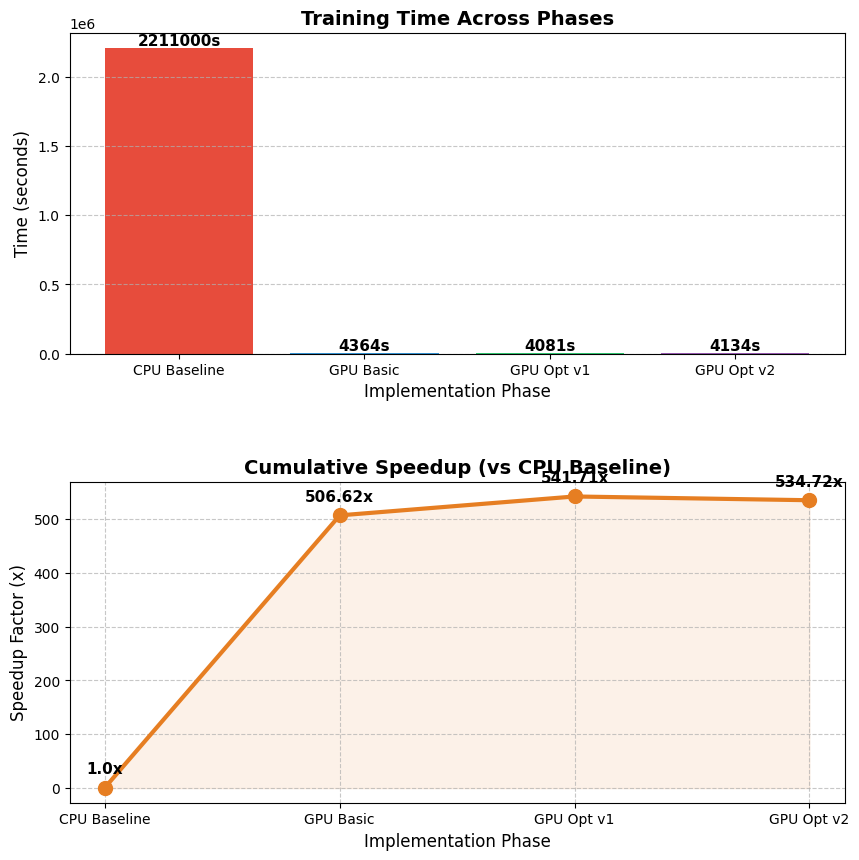

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Dữ liệu từ bảng
phases = ['CPU Baseline', 'GPU Basic', 'GPU Opt v1', 'GPU Opt v2']
training_time = [2211000, 4364.2, 4081.53, 	4134.89]       # Đơn vị: giây (s)
speedup_cumulative = [1.0, 506.62, 541.71, 534.72] # Speedup vs CPU

# Thiết lập kích thước biểu đồ (2 biểu đồ con: trên và dưới)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4) # Khoảng cách giữa 2 biểu đồ

# --- Biểu đồ 1: Bar Chart - Training Time ---
bars = ax1.bar(phases, training_time, color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
ax1.set_title('Training Time Across Phases', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_xlabel('Implementation Phase', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn giá trị lên trên các cột
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{int(height)}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Biểu đồ 2: Line Graph - Cumulative Speedup ---
ax2.plot(phases, speedup_cumulative, marker='o', linewidth=3, markersize=10, color='#e67e22', linestyle='-')
ax2.set_title('Cumulative Speedup (vs CPU Baseline)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Speedup Factor (x)', fontsize=12)
ax2.set_xlabel('Implementation Phase', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Tô màu vùng dưới đường biểu đồ cho đẹp mắt
ax2.fill_between(phases, speedup_cumulative, color='#e67e22', alpha=0.1)

# Thêm nhãn giá trị tại các điểm nút
for i, txt in enumerate(speedup_cumulative):
    ax2.annotate(f'{txt}x',
                 (phases[i], speedup_cumulative[i]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center', fontsize=11, fontweight='bold')

# Hiển thị biểu đồ
plt.show()

# **Section 4: Lessons Learned and Challenges Overcome**

### **1. Key Technical Insights**

Trong quá trình thực hiện đồ án, nhóm đã học được những điều sau:
- **CUDA Programming:** Nâng cao đáng kể kỹ năng lập trình và debug trên nền tảng CUDA C++. thông qua quá trình thực hiện, nhóm đã rèn luyện được sự thành thạo trong việc viết các kernel phức tạp, quản lý bộ nhớ, cũng như khả năng phân tích và tối ưu hóa code cho một mô hình phức tạp.
- **Deep Learning:** Việc tự cài đặt mô hình Autoencoder bằng tay thay vì dùng Framework có sẵn (như PyTorch/TensorFlow) giúp nhóm hiểu rõ bản chất toán học của mô hình
- **Performance Optimization:** Nhóm rèn luyện được kĩ năng tìm ra bottleneck của mô hình và nghĩ ra giải pháp tối ưu hóa phù hợp. Trong quá trình tìm hiểu nhóm cũng học được nhiều phương pháp tối ưu hóa thú vị.

### **2. Major Challenges and Solutions**

**Challenge 1**: Khó khăn khi ánh xạ chỉ số trong Backward Pass với Stride
- **Problem:** Việc tính toán chỉ số (indexing) để map ngược gradient từ Output về Input trong Conv2D Backward khi có stride > 1 rất phức tạp, thường xuyên gây ra lỗi truy cập sai vùng nhớ hoặc tính sai gradient.
- **Solution:** Nhóm đã vẽ sơ đồ luồng dữ liệu ra giấy để tìm quy luật ánh xạ ih = oh * stride + kh - padding, sau đó sử dụng các điều kiện kiểm tra if (oh % stride == 0) để lọc các pixel không tham gia tính toán.
- **Lesson:** Trước khi code CUDA, cần phải mô hình hóa công thức toán học và kiểm tra biên (boundary check) thật kỹ lưỡng

**Challenge 2**: Suy giảm hiệu năng mô hình do Atomic operation
- **Problem:** Trong kernel tính MSE Loss và Backward MaxPool, việc hàng chục nghìn thread cùng gọi atomicAdd vào một địa chỉ bộ nhớ gây ra hiện tượng tuần tự hóa (serialization), khiến GPU chạy chậm hơn cả mong đợi.
- **Solution:** Trong phiên bản Optimized, nhóm đã thay thế việc cộng trực tiếp bằng kỹ thuật Shared Memory để giảm số lần truy cập Global atomic.
- **Lesson:** Cần hạn chế tối đa việc xung đột bộ nhớ (memory contention) giữa các thread; atomic operation là công cụ mạnh nhưng cần dùng đúng chỗ.

**Challenge 3**: Sự thiếu kinh nghiệm về lập trình song song
- **Problem:**
  - Nhóm gặp khó khăn lớn trong giai đoạn đầu khi chuyển đổi từ tư duy lập trình tuần tự trên CPU sang tư duy song song hóa khối lượng lớn trên GPU. Việc ánh xạ các thuật toán từ logic CPU sang cấu trúc Kernel CUDA đòi hỏi sự hiểu biết sâu sắc về phần cứng mà nhóm chưa có nhiều kinh nghiệm thực tiễn.
  - Trong giai đoạn Optimized, nhóm nhận thấy việc tối ưu không chỉ là tinh chỉnh code mà có thể thay đổi phần lớn workflow của phiên bản Naive. Việc thử nghiệm và sai trong các kỹ thuật quản lý bộ nhớ đã tiêu tốn nhiều thời gian hơn dự kiến, dẫn đến các lỗi về đồng bộ hóa.
- **Solution:**
  - Nhóm đã dành nhiều thời gian nghiên cứu về một số code mẫu và các mô hình Autoencoder mẫu để hiểu rõ cách GPU điều phối luồng.
  - Thay vì tối ưu toàn bộ cùng lúc, nhóm thực hiện tối ưu hóa từng phần, giúp việc kiểm soát lỗi trở nên dễ dàng hơn.
- **Lesson:** Dù gặp nhiều khó khăn, kết quả cuối cùng đã minh chứng rõ ràng cho sức mạnh của GPU. Nhóm đã xây dựng thành công thang đo hiệu suất thực tế: CPU << Naive GPU < Optimized GPU, khẳng định tính đúng đắn của các kỹ thuật tối ưu hóa đã chọn.


# **Section 5: Conclusion and Future Work**

## **1. Project Summary**
- Dự án đã xây dựng thành công một hệ thống Convolutional Autoencoder để tái tạo ảnh CIFAR-10, được hiện thực hoàn toàn bằng CUDA C++.
- Nhóm triển khai phiên bản CPU Baseline nhằm kiểm chứng tính đúng đắn của thuật toán, bao gồm forward pass, backward pass và cập nhật trọng số.
- Phiên bản Naive GPU được tạo ra bằng cách ánh xạ trực tiếp các hàm từ CPU sang CUDA kernel, bước đầu khai thác khả năng song song của GPU.
- Hệ thống tiếp tục được tối ưu với các kỹ thuật GPU hiệu năng cao, bao gồm:
  - Shared Memory Tiling cho các phép tích chập
  - Loop Unrolling để cải thiện Instruction-Level Parallelism
  - Pinned Memory nhằm giảm chi phí truyền dữ liệu giữa CPU và GPU.
- Cuối cùng, encoder đã được tích hợp vào pipeline phân loại hai giai đoạn (Autoencoder + SVM) để đánh giá chất lượng đặc trưng học được.

## **2. Key Achievements**
- Maximum speedup ≈ 541x
- Train classification accuracy ≈ 65%
- Test classification accurancy ≈ 61%
- Most successful optimization: Memory Optimization (Sử dụng Shared memory)
- Technical skills mastered: Kĩ năng lập trình CUDA-C++, kiến thức deep learning

## **3. Limitations**
Mặc dù hệ thống đã đạt được các mục tiêu chính về chức năng và hiệu năng, vẫn tồn tại một số hạn chế đáng chú ý liên quan đến độ chính xác, nút thắt hiệu năng và ràng buộc trong triển khai.
- **Accuracy limitations:**
  - Việc sử dụng Mean Squared Error (MSE) làm hàm mất mát chính cho Autoencoder dẫn đến xu hướng tái tạo ảnh bị làm mịn, làm mất các chi tiết cao tần như cạnh sắc và kết cấu bề mặt.
  - Do MSE đo lường sự khác biệt theo từng pixel một cách độc lập, mô hình chưa khai thác hiệu quả các mối quan hệ không gian phức tạp, từ đó giới hạn chất lượng đặc trưng trích xuất cho các tác vụ phân loại.
- **Current performance bottlenecks:**
  - Mặc dù đã triển khai huấn luyện theo batch, mức cải thiện tốc độ chưa đạt như kỳ vọng.
  - Kết quả profiling cho thấy quá trình điều phối giữa CPU và GPU trong vòng lặp huấn luyện vẫn còn chi phí đáng kể, khiến GPU không được khai thác tối đa và thường xuyên rơi vào trạng thái chờ lệnh.
  - Điều này cho thấy pipeline huấn luyện hiện tại vẫn còn bị chi phối bởi chi phí quản lý luồng từ phía CPU.
- **Implementation constraints:**
  - Nhóm đã thử nghiệm Multi-Stream Pipeline bằng cách sử dụng `cudaStream_t` nhằm overlap quá trình truyền dữ liệu (H2D) và tính toán kernel.
  - Tuy nhiên, việc quản lý đồng bộ hóa giữa các stream, kiểm soát bộ nhớ không đồng bộ và đảm bảo tính đúng đắn của dữ liệu tỏ ra phức tạp trong phạm vi thời gian của dự án.
  - Do phiên bản Multi-stream chưa đạt được độ ổn định cần thiết, giải pháp này chưa được tích hợp vào bản nộp cuối cùng nhằm đảm bảo tính toàn vẹn và khả năng tái lập của hệ thống.


## **4. Future Improvements**

Những hạn chế được quan sát trong quá trình thực nghiệm không được xem là thất bại, mà là các bài học quan trọng phản ánh độ phức tạp của các hệ thống tính toán song song trong thực tế. Từ đó, chúng mở ra các hướng cải tiến rõ ràng cho những giai đoạn phát triển và tối ưu hóa chuyên sâu hơn trong tương lai.

Dựa trên kinh nghiệm triển khai và kết quả profiling, nhóm đề xuất một số hướng cải tiến trọng tâm nhằm nâng cao **chất lượng biểu diễn** và **hiệu suất thực thi** của hệ thống:

1. **Cải thiện hàm mất mát (Loss Function)**
   - Thay thế hoặc kết hợp **MSE** với các hàm loss tiên tiến hơn như **SSIM (Structural Similarity Index)** hoặc **Perceptual Loss** dựa trên feature map của các mạng tiền huấn luyện (ví dụ: VGG), nhằm bảo toàn tốt hơn các cấu trúc không gian và chi tiết cao tần trong ảnh tái tạo.

2. **Tăng cường khả năng học biểu diễn**
   - Thử nghiệm tích hợp các cơ chế **Attention** vào kiến trúc Autoencoder để giúp mô hình tập trung tốt hơn vào các vùng thông tin quan trọng và chi tiết tinh vi của ảnh đầu vào.

3. **Hoàn thiện Multi-Stream Pipeline**
   - Triển khai đầy đủ pipeline đa luồng sử dụng `cudaStream_t` kết hợp với `cudaMemcpyAsync` nhằm chồng chéo hiệu quả giữa truyền dữ liệu và tính toán kernel, từ đó giảm thời gian chờ và nâng cao mức độ sử dụng GPU.

4. **Tối ưu giao tiếp nội bộ trên GPU**
   - Thay thế một phần các thao tác dựa trên **Shared Memory** bằng các lệnh **Warp Shuffle**, cho phép trao đổi dữ liệu trực tiếp giữa các thread trong cùng một warp, giúp giảm độ trễ và hạn chế xung đột bộ nhớ.

5. **Tối ưu hóa pipeline dữ liệu phía CPU**
   - Cải thiện bộ nạp dữ liệu bằng cách sử dụng **đa luồng** để tiền xử lý ảnh và đưa dữ liệu vào **Pinned Memory** trước khi GPU yêu cầu.
   - Hướng tiếp cận này có tiềm năng tối ưu hóa hiệu quả hơn các **Batched Operations**, đồng thời giảm chi phí điều phối giữa CPU và GPU.
